# Defining MLP

In [645]:
import os
os.chdir('/Users/mikolajmroz/Developer/Computational_Intelligence_Methods')
print(os.getcwd())

/Users/mikolajmroz/Developer/Computational_Intelligence_Methods


In [646]:
import numpy as np
import pandas as pd 
import matplotlib as plt
import matplotlib.pyplot as plt


In [647]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [648]:
def sigmoid_derivative(x):
    # Corrected sigmoid derivative to properly compute the derivative
    return sigmoid(x) * (1 - sigmoid(x))

In [649]:
def mse(predictions, targets):
    return np.mean((predictions - targets) ** 2)

In [695]:
class MLP:
    def __init__(self, layer_sizes,function='sigmoid'):
        self.layer_sizes = layer_sizes
        self.weights = [
            np.random.randn(y, x) * np.sqrt(1.0 / x)
            for x, y in zip(layer_sizes[:-1], layer_sizes[1:])
        ]
        self.biases = [np.random.randn(y, 1) for y in layer_sizes[1:]]

        print(self.weights)

    def print_final_weights_and_biases(self):
        print("Final Weights and Biases:")
        for i, (w, b) in enumerate(zip(self.weights, self.biases)):
            print(f"Layer {i + 1} Weights:\n{w}")
            print(f"Layer {i + 1} Biases:\n{b}")

    def feedforward(self, a):
        activations = [a]  # Stores all activations
        for b, w in zip(self.biases[:-1], self.weights[:-1]):
            a = sigmoid(np.dot(w, a)+ b) 
            activations.append(a)
        # Linear activation for the last layer
        a = np.dot(self.weights[-1], a) + self.biases[-1]
        activations.append(a)
        return activations[-1], activations  # Return final activation and all activations

    def backprop(self, x, y):
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        final_output, activations = self.feedforward(x)
        zs = [np.dot(w, act) + b for w, b, act in zip(self.weights, self.biases, activations[:-1])]  # Z values

        # Output layer error
        delta = self.cost_derivative(final_output, y)
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].T)

        # Backpropagate the error
        for l in range(2, len(self.layer_sizes)):
            sp = sigmoid_derivative(zs[-l])
            delta = np.dot(self.weights[-l + 1].T, delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l - 1].T)

        return nabla_w, nabla_b

    def update_mini_batch(self, mini_batch, learning_rate, lambda_, n):
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        for x, y in mini_batch:
            delta_nabla_w, delta_nabla_b = self.backprop(x, y)
            nabla_w = [nw + dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
            nabla_b = [nb + dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]

        # Update weights with L2 regularization
        self.weights = [(1 - learning_rate * (lambda_ / n)) * w - (learning_rate / len(mini_batch)) * nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b - (learning_rate / len(mini_batch)) * nb for b, nb in zip(self.biases, nabla_b)]

    def train(self, training_data, epochs, learning_rate, batch_size, lambda_=0.0, update_method='batch',
              plot_interval=None, visual_interval=100, mse_limit=None, X_val_scaled=None, y_val_scaled=None, X_val=None, y_val=None,
              scaler_X=None, scaler_y=None):
        
        mse_history = []
        n = len(training_data)
        learning_rate_init = learning_rate
        for j in range(epochs):
            # Plot weights at the specified interval
            if plot_interval and j % plot_interval == 0:
                print(f"Epoch {j}:")
                self.plot_weights()

            np.random.shuffle(training_data)
            if update_method == 'batch':
                mini_batches = [training_data[k:k + batch_size] for k in range(0, n, batch_size)]
                for mini_batch in mini_batches:
                    self.update_mini_batch(mini_batch, learning_rate, lambda_, n)
            elif update_method == 'epoch':
                self.update_mini_batch(training_data, learning_rate, lambda_, n)
            # Learning rate schedule
            learning_rate = learning_rate_init / (1 + 0.01 * j)
            
            if j % visual_interval == 0 or j == epochs - 1:
                # Generate predictions for the validation set
                predictions_scaled_mse = np.array(
                    [self.feedforward(x.reshape(-1, 1))[0] for x in X_val_scaled])
    
                # Inverse transform the scaled predictions back to their original scale
                predictions_mse = scaler_y.inverse_transform(predictions_scaled_mse.reshape(-1, 1))
    
                # Calculate the mean squared error on the validation set
                current_mse = mse(predictions_mse, y_val)
                # Append the MSE to the history for tracking
                mse_history.append((j, current_mse))
                # Print the current epoch and its MSE
                print(f'Epoch {j}, MSE: {current_mse}')
    
                # If a threshold for MSE is set and the current MSE is below this threshold, stop training
                if mse_limit is not None and current_mse < mse_limit:
                    break
    
        # Return the history of MSE values
        return mse_history

    def cost_derivative(self, output_activations, y):
        return (output_activations - y)
    
    
    def visualize_network_working(self):
        fig, ax = plt.subplots()

        # For each layer
        for i in range(len(self.layer_sizes)):
            # Draw the nodes of the layer
            ax.scatter([i]*self.layer_sizes[i], range(self.layer_sizes[i]))

            # Draw the weights connecting the nodes of the current layer to the next layer
            if i < len(self.layer_sizes) - 1:
                for j in range(self.layer_sizes[i]):
                    for k in range(self.layer_sizes[i+1]):
                        weight = self.weights[i][k, j]
                        color = 'g' if weight >= 0 else 'r'
                        ax.plot([i, i+1], [j, k], color=color)

        plt.show()
        
    def visualize_network(self):
        fig, ax = plt.subplots()
    
        # For each layer
        for i in range(len(self.layer_sizes)):
            # Draw the nodes of the layer
            ax.scatter([i]*self.layer_sizes[i], range(self.layer_sizes[i]))
    
            # Draw the weights connecting the nodes of the current layer to the next layer
            if i < len(self.layer_sizes) - 1:
                for j in range(self.layer_sizes[i]):
                    for k in range(self.layer_sizes[i+1]):
                        weight = self.weights[i][k, j]
                        color = 'g' if weight >= 0 else 'r'
                        ax.plot([i, i+1], [j, k], color=color)
                        # Add weight value on the line
                        ax.text(i + 0.5, (j + k) / 2, f'{weight:.2f}', color=color, ha='center')
    
            
    
        plt.show()

In [696]:
class DataScaler:
    def __init__(self, method="standardization"):
        self.method = method
        self.min = None
        self.max = None
        self.mean = None
        self.std = None

    def fit_transform(self, data):
        if self.method == "min_max":
            return self.fit_transform_min_max(data)
        elif self.method == "standardization":
            return self.fit_transform_standardization(data)
        else:
            raise ValueError("Unsupported scaling method")

    def transform(self, data):
        if self.method == "min_max":
            return self.transform_min_max(data)
        elif self.method == "standardization":
            return self.transform_standardization(data)
        else:
            raise ValueError("Unsupported scaling method")

    def inverse_transform(self, data):
        if self.method == "min_max":
            return self.inverse_transform_min_max(data)
        elif self.method == "standardization":
            return self.inverse_transform_standardization(data)
        else:
            raise ValueError("Unsupported scaling method")

    def fit_transform_min_max(self, data):
        self.min = np.min(data, axis=0)
        self.max = np.max(data, axis=0)
        return (data - self.min) / (self.max - self.min)

    def transform_min_max(self, data):
        return (data - self.min) / (self.max - self.min)

    def inverse_transform_min_max(self, data):
        return data * (self.max - self.min) + self.min

    def fit_transform_standardization(self, data):
        self.mean = np.mean(data, axis=0)
        self.std = np.std(data, axis=0)
        return (data - self.mean) / self.std

    def transform_standardization(self, data):
        return (data - self.mean) / self.std

    def inverse_transform_standardization(self, data):
        return data * self.std + self.mean


# Loading data

In [697]:
df_train_square_simple = pd.read_csv('./data/regression/square-simple-training.csv')
df_test_square_simple = pd.read_csv('./data/regression/square-simple-test.csv')

In [698]:
df_train_steps_small = pd.read_csv('./data/regression/steps-small-training.csv')
df_test_steps_small = pd.read_csv('./data/regression/steps-small-test.csv')

In [699]:
df_train_multimodal_large = pd.read_csv('./data/regression/multimodal-large-training.csv')
df_test_multimodal_large = pd.read_csv('./data/regression/multimodal-large-test.csv')

In [700]:
X_train_square_simple = df_train_square_simple['x'].values.reshape(-1, 1)
y_train_square_simple = df_train_square_simple['y'].values.reshape(-1, 1)

In [701]:
X_test_square_simple = df_test_square_simple['x'].values.reshape(-1, 1)
y_test_square_simple = df_test_square_simple['y'].values.reshape(-1, 1)

In [702]:
X_train_steps_small = df_train_steps_small['x'].values.reshape(-1, 1)
y_train_steps_small = df_train_steps_small['y'].values.reshape(-1, 1)

In [703]:
X_test_steps_small = df_test_steps_small['x'].values.reshape(-1, 1)
y_test_steps_small = df_test_steps_small['y'].values.reshape(-1, 1)

In [704]:
X_train_multimodal_large = df_train_multimodal_large['x'].values.reshape(-1, 1)
y_train_multimodal_large = df_train_multimodal_large['y'].values.reshape(-1, 1)

In [705]:
X_test_multimodal_large = df_test_multimodal_large['x'].values.reshape(-1, 1)
y_test_multimodal_large = df_test_multimodal_large['y'].values.reshape(-1, 1)

### square-simple dataset

In [706]:
scaler_X = DataScaler(method="standardization")
scaler_y = DataScaler(method="standardization")

In [707]:
# Fit and transform the training data
X_train_scaled = scaler_X.fit_transform(X_train_square_simple)
y_train_scaled = scaler_y.fit_transform(y_train_square_simple)


In [708]:
X_test_scaled = scaler_X.transform(X_test_square_simple)
y_test_scaled = scaler_y.transform(y_test_square_simple)

In [709]:
training_data = [(x.reshape(-1, 1), y) for x, y in zip(X_train_square_simple, y_train_square_simple)]

In [710]:
mlp_square_1_5 = MLP([1, 5, 5, 1])

[array([[ 1.01038182],
       [-0.58665196],
       [ 0.83752706],
       [ 2.13633367],
       [ 1.04169877]]), array([[ 0.54036195, -0.53201001,  0.39204488, -0.47391994,  0.14137536],
       [ 0.48456408,  0.55064089, -0.09026996,  0.76972222,  0.14203101],
       [-0.37268803, -0.66452297, -0.45906238,  0.94576645,  0.8046944 ],
       [ 0.24854155, -0.44501767,  0.14706578,  0.62945003, -0.56517764],
       [-0.19084423,  0.62423529,  0.2840362 , -0.07467296,  0.89447339]]), array([[-0.06054717,  0.44643914,  0.45680898,  0.10663163, -0.02412577]])]


In [711]:
training_data_scaled = [
    (x.reshape(-1, 1), y) for x, y in zip(X_train_scaled, y_train_scaled)
]

In [717]:
mlp_square_1_5 = MLP([1, 5, 5, 1])

[array([[-0.26498988],
       [ 0.44632801],
       [-1.86324125],
       [ 0.7324358 ],
       [ 0.32016054]]), array([[-0.26662756,  0.06020135, -0.49122727,  0.14910104,  0.02740932],
       [ 0.11970871, -0.01450294, -0.11608353,  0.41985196,  0.8467151 ],
       [-0.00871157, -0.38901817, -0.46004746, -0.29363194, -0.15158857],
       [ 0.83213757, -0.0214645 ,  0.21051269, -0.26291228,  0.13001732],
       [-0.12042978, -0.02470988, -0.76508031,  0.61251426,  0.19056981]]), array([[ 0.15673372, -0.16959091,  0.21826293, -0.13892511, -0.13516077]])]


In [713]:
mse1_04_batch = mlp_square_1_5.train(
    training_data_scaled, epochs=15000, learning_rate=0.4, batch_size=1,
    X_val_scaled=X_test_scaled, y_val_scaled=y_test_scaled, X_val=X_test_square_simple, y_val=y_test_square_simple,
    scaler_X=scaler_X, scaler_y=scaler_y, mse_limit=4, update_method='batch'
)

Epoch 0, MSE: 6886.673371633751
Epoch 100, MSE: 19.275198019736596
Epoch 200, MSE: 6.962796229825027
Epoch 300, MSE: 5.358321791570153
Epoch 400, MSE: 1.3297896509689366


In [718]:
mse1_04_epoch = mlp_square_1_5.train(
    training_data_scaled, epochs=30000, learning_rate=0.4, batch_size=1,
    X_val_scaled=X_test_scaled, y_val_scaled=y_test_scaled, X_val=X_test_square_simple, y_val=y_test_square_simple,
    scaler_X=scaler_X, scaler_y=scaler_y, mse_limit=4, update_method='epoch'
)

Epoch 0, MSE: 7251.161470579673
Epoch 100, MSE: 6806.829079090326
Epoch 200, MSE: 6217.896716474952
Epoch 300, MSE: 5558.190887515234
Epoch 400, MSE: 4967.248355845616
Epoch 500, MSE: 4476.52767332076
Epoch 600, MSE: 4073.087118703887
Epoch 700, MSE: 3741.599467992234
Epoch 800, MSE: 3469.467135696354
Epoch 900, MSE: 3245.88397491188
Epoch 1000, MSE: 3061.468412600663
Epoch 1100, MSE: 2908.3066895212314
Epoch 1200, MSE: 2779.946838311161
Epoch 1300, MSE: 2671.261615293745
Epoch 1400, MSE: 2578.238798860097
Epoch 1500, MSE: 2497.7605916961097
Epoch 1600, MSE: 2427.4064119962804
Epoch 1700, MSE: 2365.2909823188597
Epoch 1800, MSE: 2309.9374910232928
Epoch 1900, MSE: 2260.1807185189987
Epoch 2000, MSE: 2215.093960831333
Epoch 2100, MSE: 2173.9341429714973
Epoch 2200, MSE: 2136.100564618718
Epoch 2300, MSE: 2101.1037720068616
Epoch 2400, MSE: 2068.5419342648383
Epoch 2500, MSE: 2038.0827911217232
Epoch 2600, MSE: 2009.4497546942212
Epoch 2700, MSE: 1982.4111267817611
Epoch 2800, MSE: 1956.

In [719]:
mse1_04_batch = list_to_dataframe(mse1_04_batch)
mse1_04_epoch = list_to_dataframe(mse1_04_epoch)

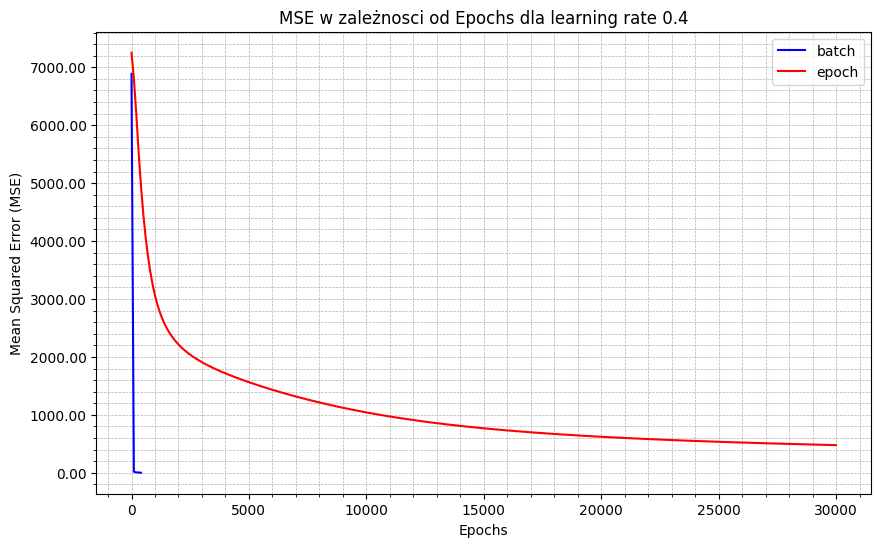

In [721]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_mse(datasets, labels, colors):
    """
    Plots MSE over epochs for given datasets with denser axes.
    
    Parameters:
    - datasets: List of Pandas DataFrames, each containing 'Epoch' and 'MSE' columns.
    - labels: List of labels for the datasets, for the legend.
    - colors: List of colors for the datasets.
    """
    plt.figure(figsize=(10, 6))
    
    ax = plt.gca()  # Get the current Axes instance on the current figure matching the given keyword args, or create one.
    
    for df, label, color in zip(datasets, labels, colors):
        plt.plot(df['Epoch'], df['MSE'], label=label, color=color)
    
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('MSE w zależnosci od Epochs dla learning rate 0.4')
    
    # Set denser x-axis and y-axis
    ax.xaxis.set_major_locator(ticker.AutoLocator())  # Automatically determine the tick locations
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())  # Subdivisions of the major ticks
    ax.yaxis.set_major_locator(ticker.AutoLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    
    # Optionally, you can format tick labels for readability, e.g., limiting the decimal places for MSE
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    
    plt.legend()
    plt.grid(visible=True, which='both', axis='both', linestyle='--', linewidth=0.5)  # Enhanced grid visibility
    plt.show()

# Assuming mse1_01, mse50_01, mse100_01, mse200_01 are your datasets as DataFrames
datasets = [mse1_04_batch, mse1_04_epoch]
labels = ['batch', 'epoch']
colors = ['blue', 'red']

plot_mse(datasets, labels, colors)


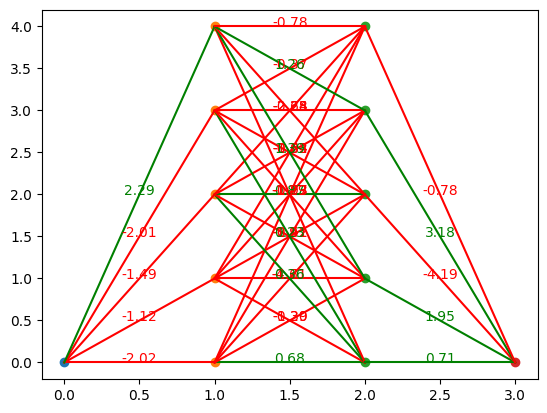

In [576]:
mlp_square_1_5.visualize_network()

In [577]:
mlp_square_1_5 = MLP([1, 5, 5, 1])

[array([[ 0.40536054],
       [ 0.83113095],
       [ 0.02608059],
       [-0.27132577],
       [ 0.45896424]]), array([[-0.03898054, -0.39863828, -0.0153136 ,  0.25074188,  0.07212428],
       [ 0.61220529,  0.49559955, -0.30907901, -0.20531566, -0.30796144],
       [-0.37378029, -0.00249444, -0.6119147 ,  0.64538481, -0.36048333],
       [ 0.01774514, -0.32465998,  0.08074966, -0.50215465,  0.17390445],
       [ 0.22367694,  0.62474868, -0.22929074,  0.27911063,  0.3760241 ]]), array([[ 0.35034599,  0.99610106,  0.04590305,  0.10557161, -0.59321167]])]


In [578]:
mse50_04 = mlp_square_1_5.train(
    training_data_scaled, epochs=15000, learning_rate=0.4, batch_size=50,
    X_val_scaled=X_test_scaled, y_val_scaled=y_test_scaled, X_val=X_test_square_simple, y_val=y_test_square_simple,
    scaler_X=scaler_X, scaler_y=scaler_y, mse_limit=4
)

Epoch 0, MSE: 7099.038308695716
Epoch 100, MSE: 2671.270173233133
Epoch 200, MSE: 2010.9570607022615
Epoch 300, MSE: 1869.4780743737524
Epoch 400, MSE: 1814.5494908319283
Epoch 500, MSE: 1784.1251788139075
Epoch 600, MSE: 1761.7966150802135
Epoch 700, MSE: 1743.6000035318395
Epoch 800, MSE: 1725.9214521040633
Epoch 900, MSE: 1709.8439346945636
Epoch 1000, MSE: 1694.4118305067375
Epoch 1100, MSE: 1679.2898791602618
Epoch 1200, MSE: 1664.8404588902965
Epoch 1300, MSE: 1649.898851065499
Epoch 1400, MSE: 1634.909954359723


KeyboardInterrupt: 

In [203]:
mlp_square_1_5 = MLP([1, 5, 5, 1])

[array([[-0.37556227],
       [ 0.28196147],
       [-0.32683007],
       [ 0.18094847],
       [ 0.94852717]]), array([[-0.19203626,  0.52514429, -0.44761725,  0.11828722, -0.63120012],
       [ 0.33877664,  0.08807317,  0.28080312,  0.02767062, -0.53059349],
       [-0.00506171,  0.68199311,  0.09661987, -0.04047895,  0.07408978],
       [ 0.05656276, -0.54470859, -0.67751827, -0.42548959, -0.44771847],
       [-0.80210891, -0.12679892,  0.19661029,  0.15294795, -0.75811977]]), array([[ 0.70768204, -0.22920111, -0.60493497, -0.0448078 ,  0.61554686]])]


In [204]:
mse100_04 = mlp_square_1_5.train(
    training_data_scaled, epochs=15000, learning_rate=0.4, batch_size=100,
    X_val_scaled=X_test_scaled, y_val_scaled=y_test_scaled, X_val=X_test_square_simple, y_val=y_test_square_simple,
    scaler_X=scaler_X, scaler_y=scaler_y, mse_limit=4
)

Epoch 0, MSE: 8062.7947965108415
Epoch 100, MSE: 6430.211387033204
Epoch 200, MSE: 4627.60373803938
Epoch 300, MSE: 3587.8769565934367
Epoch 400, MSE: 3050.4291531889085
Epoch 500, MSE: 2729.187047921289
Epoch 600, MSE: 2522.3332555183447
Epoch 700, MSE: 2380.8438846231006
Epoch 800, MSE: 2279.090720239269
Epoch 900, MSE: 2202.821872684172
Epoch 1000, MSE: 2143.6461523152534
Epoch 1100, MSE: 2096.3711685862163
Epoch 1200, MSE: 2057.6443634046645
Epoch 1300, MSE: 2025.2209062928648
Epoch 1400, MSE: 1997.5498720020544
Epoch 1500, MSE: 1973.5302351202367
Epoch 1600, MSE: 1952.3615647261895
Epoch 1700, MSE: 1933.4496383784538
Epoch 1800, MSE: 1916.345030207343
Epoch 1900, MSE: 1900.7021175192506
Epoch 2000, MSE: 1886.2510844574467
Epoch 2100, MSE: 1872.7784058258892
Epoch 2200, MSE: 1860.1129886266142
Epoch 2300, MSE: 1848.1161651724613
Epoch 2400, MSE: 1836.6743567508563
Epoch 2500, MSE: 1825.6936202231655
Epoch 2600, MSE: 1815.0955427687375
Epoch 2700, MSE: 1804.814115607932
Epoch 2800, 

In [205]:
mlp_square_1_5 = MLP([1, 5, 5, 1])

[array([[-0.14042995],
       [ 0.76347642],
       [-0.51397612],
       [-0.67097226],
       [ 0.61095129]]), array([[ 0.08232473,  0.62675145, -0.65088084,  0.27555415, -0.05927419],
       [-0.18533489, -0.2318229 ,  0.16796487,  0.06385699, -0.4570434 ],
       [ 0.04886531, -0.56770821,  0.02151936,  0.50245825, -0.8583055 ],
       [-0.11086829, -0.12364977, -0.15772622,  0.46035663, -0.34104641],
       [ 0.15396222,  0.09289556,  0.07452162,  0.10031759, -0.51657679]]), array([[ 0.3280634 , -0.11309452,  0.00924617,  0.40952644,  1.35357167]])]


In [206]:
mse200_04 = mlp_square_1_5.train(
    training_data_scaled, epochs=15000, learning_rate=0.4, batch_size=200,
    X_val_scaled=X_test_scaled, y_val_scaled=y_test_scaled, X_val=X_test_square_simple, y_val=y_test_square_simple,
    scaler_X=scaler_X, scaler_y=scaler_y, mse_limit=4
)

Epoch 0, MSE: 7381.416905820523
Epoch 100, MSE: 7014.279466033039
Epoch 200, MSE: 6600.471020629339
Epoch 300, MSE: 6092.63643565544
Epoch 400, MSE: 5569.129940921488
Epoch 500, MSE: 5074.597692483842
Epoch 600, MSE: 4624.5285110007235
Epoch 700, MSE: 4228.216273966903
Epoch 800, MSE: 3888.1984161944165
Epoch 900, MSE: 3600.4329743430612
Epoch 1000, MSE: 3357.641058468183
Epoch 1100, MSE: 3152.0233429310783
Epoch 1200, MSE: 2976.5749444774715
Epoch 1300, MSE: 2825.4804397577996
Epoch 1400, MSE: 2694.0821712233633
Epoch 1500, MSE: 2578.7028765355
Epoch 1600, MSE: 2476.4480138822514
Epoch 1700, MSE: 2385.032499968839
Epoch 1800, MSE: 2302.641812117066
Epoch 1900, MSE: 2227.8247921416637
Epoch 2000, MSE: 2159.412151935573
Epoch 2100, MSE: 2096.454734625153
Epoch 2200, MSE: 2038.17662191512
Epoch 2300, MSE: 1983.9393127488024
Epoch 2400, MSE: 1933.2141591272261
Epoch 2500, MSE: 1885.560986806143
Epoch 2600, MSE: 1840.611378909227
Epoch 2700, MSE: 1798.0555016938565
Epoch 2800, MSE: 1757.63

In [207]:
mlp_square_1_5 = MLP([1, 5, 5, 1])

[array([[-0.11404613],
       [ 0.68260319],
       [ 1.19353181],
       [ 1.03140797],
       [ 0.05711491]]), array([[-0.19863137, -0.24873408, -0.00226238, -0.60981582, -0.0307433 ],
       [-0.17288719,  0.3055975 , -0.31162651, -0.27460685,  0.13593605],
       [ 0.20263749,  0.02404213,  0.47411717, -0.39212838,  1.27099741],
       [ 0.51125792,  0.71293478,  0.72733506,  0.39551588,  0.58473837],
       [-0.92095756,  0.12206519,  0.28762443,  0.14563575,  0.35628274]]), array([[-0.68224743, -0.35432953,  0.13878906,  0.34907956, -0.31296743]])]


In [208]:
mse1_01 = mlp_square_1_5.train(
    training_data_scaled, epochs=15000, learning_rate=0.1, batch_size=1,
    X_val_scaled=X_test_scaled, y_val_scaled=y_test_scaled, X_val=X_test_square_simple, y_val=y_test_square_simple,
    scaler_X=scaler_X, scaler_y=scaler_y, mse_limit=4
)

Epoch 0, MSE: 7034.417301194592
Epoch 100, MSE: 15.764397001007643
Epoch 200, MSE: 8.060425491498258
Epoch 300, MSE: 7.454768786946264
Epoch 400, MSE: 6.1503888136489
Epoch 500, MSE: 5.971048663893567
Epoch 600, MSE: 5.8073377721977515
Epoch 700, MSE: 5.433784120564349
Epoch 800, MSE: 5.9063812653221035
Epoch 900, MSE: 5.717565181741553
Epoch 1000, MSE: 5.47577059436761
Epoch 1100, MSE: 4.947690754977472
Epoch 1200, MSE: 4.902911164090541
Epoch 1300, MSE: 4.85308941888271
Epoch 1400, MSE: 4.614576851826795
Epoch 1500, MSE: 4.604481251145915
Epoch 1600, MSE: 4.640576197125101
Epoch 1700, MSE: 4.859761885172977
Epoch 1800, MSE: 4.906472686677017
Epoch 1900, MSE: 4.781575988556287
Epoch 2000, MSE: 4.673972022014535
Epoch 2100, MSE: 4.846757182037179
Epoch 2200, MSE: 4.493120989218923
Epoch 2300, MSE: 4.468068325580044
Epoch 2400, MSE: 4.403632073128602
Epoch 2500, MSE: 4.530826216860683
Epoch 2600, MSE: 4.300417341047196
Epoch 2700, MSE: 4.3371591929150926
Epoch 2800, MSE: 4.2345479418686

In [209]:
mlp_square_1_5 = MLP([1, 5, 5, 1])

[array([[-1.38418661],
       [-1.10799518],
       [ 0.40910655],
       [ 2.72344508],
       [-2.075239  ]]), array([[-1.13923254, -0.81445079, -0.0081373 , -0.38363177,  0.43502764],
       [-0.34431492,  0.05035738,  0.43824518,  0.22455391,  0.20494253],
       [-0.19757424,  0.90389901,  0.85798757,  0.43739423, -1.19028775],
       [ 0.34610862, -0.07489205,  0.35596037, -0.04955204,  0.16495035],
       [-0.67000541, -0.71652185,  0.19466252,  0.3400033 ,  0.74360558]]), array([[ 0.24244926, -0.03442921, -1.17438939, -0.06111941,  0.11392566]])]


In [210]:
mse50_01 = mlp_square_1_5.train(
    training_data_scaled, epochs=15000, learning_rate=0.1, batch_size=50,
    X_val_scaled=X_test_scaled, y_val_scaled=y_test_scaled, X_val=X_test_square_simple, y_val=y_test_square_simple,
    scaler_X=scaler_X, scaler_y=scaler_y, mse_limit=4
)

Epoch 0, MSE: 12457.144498413181
Epoch 100, MSE: 5094.8503581459945
Epoch 200, MSE: 3848.3159971961427
Epoch 300, MSE: 3302.462015823575
Epoch 400, MSE: 2977.884550650063
Epoch 500, MSE: 2753.1874674786905
Epoch 600, MSE: 2585.7153951437517
Epoch 700, MSE: 2454.696563087253
Epoch 800, MSE: 2348.46544363199
Epoch 900, MSE: 2259.908071948669
Epoch 1000, MSE: 2184.544206585714
Epoch 1100, MSE: 2119.2548675686558
Epoch 1200, MSE: 2061.874039842311
Epoch 1300, MSE: 2010.891719144431
Epoch 1400, MSE: 1965.121185663758
Epoch 1500, MSE: 1923.726941296453
Epoch 1600, MSE: 1886.0381418578793
Epoch 1700, MSE: 1851.4696144465531
Epoch 1800, MSE: 1819.6323002576758
Epoch 1900, MSE: 1790.155424962314
Epoch 2000, MSE: 1762.7216772420466
Epoch 2100, MSE: 1737.1588401606216
Epoch 2200, MSE: 1713.233156156199
Epoch 2300, MSE: 1690.756390336848
Epoch 2400, MSE: 1669.6070776933186
Epoch 2500, MSE: 1649.6491835023105
Epoch 2600, MSE: 1630.7620665315935
Epoch 2700, MSE: 1612.8517813051374
Epoch 2800, MSE: 1

In [211]:
mlp_square_1_5 = MLP([1, 5, 5, 1])

[array([[ 0.12943173],
       [ 1.37032286],
       [-1.14704998],
       [-0.80353064],
       [-0.06875761]]), array([[-0.22059364, -0.51715423,  0.21542784, -0.06631132, -0.99755362],
       [-0.42449582,  0.66530349,  0.61578319,  0.02131137, -0.15608298],
       [ 0.38500234,  0.0953978 , -0.24174079,  0.05899003, -0.30422449],
       [-1.00457292,  0.60464206,  0.23809909, -0.04334985, -0.51507636],
       [ 0.20685212, -0.20388757, -0.36788081,  0.23563315,  0.78291456]]), array([[-0.5269261 ,  0.67958142, -0.48198295,  0.24680193, -0.56627349]])]


In [212]:
mse100_01 = mlp_square_1_5.train(
    training_data_scaled, epochs=15000, learning_rate=0.1, batch_size=100,
    X_val_scaled=X_test_scaled, y_val_scaled=y_test_scaled, X_val=X_test_square_simple, y_val=y_test_square_simple,
    scaler_X=scaler_X, scaler_y=scaler_y, mse_limit=4
)

Epoch 0, MSE: 7196.101668323781
Epoch 100, MSE: 7036.9389953707005
Epoch 200, MSE: 6921.206268430868
Epoch 300, MSE: 6832.541679602029
Epoch 400, MSE: 6758.807970454967
Epoch 500, MSE: 6694.853379745854
Epoch 600, MSE: 6637.946942024398
Epoch 700, MSE: 6586.437620854767
Epoch 800, MSE: 6539.236513544649
Epoch 900, MSE: 6495.579692536667
Epoch 1000, MSE: 6454.905972438382
Epoch 1100, MSE: 6416.788186201593
Epoch 1200, MSE: 6380.891873279887
Epoch 1300, MSE: 6346.949091719945
Epoch 1400, MSE: 6314.7410847799465
Epoch 1500, MSE: 6284.086389845851
Epoch 1600, MSE: 6254.83243092191
Epoch 1700, MSE: 6226.849418969117
Epoch 1800, MSE: 6200.0258270047225
Epoch 1900, MSE: 6174.26496763604
Epoch 2000, MSE: 6149.482359892318
Epoch 2100, MSE: 6125.603672477887
Epoch 2200, MSE: 6102.563095472781
Epoch 2300, MSE: 6080.302035559885
Epoch 2400, MSE: 6058.768059046974
Epoch 2500, MSE: 6037.914027134266
Epoch 2600, MSE: 6017.697382083187
Epoch 2700, MSE: 5998.079553102713
Epoch 2800, MSE: 5979.025458145

In [213]:
mlp_square_1_5 = MLP([1, 5, 5, 1])

[array([[ 0.27780763],
       [ 0.77804587],
       [ 1.08061062],
       [ 1.0557254 ],
       [-0.46418741]]), array([[-0.10336896, -0.57228119,  0.12080522,  0.40076805, -0.22119905],
       [ 0.53655384,  0.47234824,  0.80970241,  0.22866413, -0.05068558],
       [-0.02206469, -0.0809407 , -0.97439791, -0.90881735, -0.61792982],
       [-0.66031144, -0.39452408,  0.07043176,  0.62594797,  1.02975966],
       [-0.55360805,  0.69205189,  0.27134645, -0.57343026, -0.5046887 ]]), array([[ 0.14314063, -0.10924129,  0.84784135, -0.30838119, -0.12339059]])]


In [214]:
mse200_01 = mlp_square_1_5.train(
    training_data_scaled, epochs=15000, learning_rate=0.1, batch_size=200,
    X_val_scaled=X_test_scaled, y_val_scaled=y_test_scaled, X_val=X_test_square_simple, y_val=y_test_square_simple,
    scaler_X=scaler_X, scaler_y=scaler_y, mse_limit=4
)

Epoch 0, MSE: 9413.469012766673
Epoch 100, MSE: 7183.700248139683
Epoch 200, MSE: 7005.062325866253
Epoch 300, MSE: 6857.549459527138
Epoch 400, MSE: 6725.6760205571145
Epoch 500, MSE: 6603.869396175519
Epoch 600, MSE: 6489.562886930711
Epoch 700, MSE: 6381.377552066656
Epoch 800, MSE: 6278.483520850629
Epoch 900, MSE: 6180.332380308912
Epoch 1000, MSE: 6086.5309835306
Epoch 1100, MSE: 5996.776795772275
Epoch 1200, MSE: 5910.822731958566
Epoch 1300, MSE: 5828.457186138356
Epoch 1400, MSE: 5749.492326105006
Epoch 1500, MSE: 5673.7570737032875
Epoch 1600, MSE: 5601.092823756845
Epoch 1700, MSE: 5531.350798595498
Epoch 1800, MSE: 5464.39039313186
Epoch 1900, MSE: 5400.0781240031965
Epoch 2000, MSE: 5338.286947112777
Epoch 2100, MSE: 5278.895798221982
Epoch 2200, MSE: 5221.7892664647425
Epoch 2300, MSE: 5166.857344950574
Epoch 2400, MSE: 5113.995224153683
Epoch 2500, MSE: 5063.103107386137
Epoch 2600, MSE: 5014.086036253705
Epoch 2700, MSE: 4966.85371940722
Epoch 2800, MSE: 4921.3203612715

In [260]:
mlp_square_1_5 = MLP([1, 5, 5, 1])

[array([[ 2.24510015],
       [ 0.42262484],
       [-0.97882416],
       [ 0.49920945],
       [ 1.31292029]]), array([[-0.22618034, -0.14112312, -0.42232537, -0.46995395,  0.19435486],
       [-0.61563338,  0.36804377,  0.83069677,  0.1064488 ,  0.0920191 ],
       [ 0.31035074,  0.2697029 ,  0.23966172, -0.54478081, -0.48066544],
       [-1.12313342, -0.14097009, -0.82784653,  0.45872357, -0.30714043],
       [-0.3065131 ,  0.4829027 ,  0.61726448,  0.25860346,  0.1920412 ]]), array([[-0.14972688,  0.89674879, -0.50236927,  0.03810057, -0.77547997]])]


In [286]:
mse1_001 = mlp_square_1_5.train(
    training_data_scaled, epochs=15000, learning_rate=0.01, batch_size=1,
    X_val_scaled=X_test_scaled, y_val_scaled=y_test_scaled, X_val=X_test_square_simple, y_val=y_test_square_simple,
    scaler_X=scaler_X, scaler_y=scaler_y, mse_limit=4
)

Epoch 0, MSE: 7595.808589706035
Epoch 100, MSE: 1362.1797648176457
Epoch 200, MSE: 269.35250343629724
Epoch 300, MSE: 178.39950420552157
Epoch 400, MSE: 133.22060862297243
Epoch 500, MSE: 113.94638478055998
Epoch 600, MSE: 99.16394461540402
Epoch 700, MSE: 87.52390224374176
Epoch 800, MSE: 80.3378890540548
Epoch 900, MSE: 71.834600134319
Epoch 1000, MSE: 67.86174707339053
Epoch 1100, MSE: 64.04154853358317
Epoch 1200, MSE: 60.158874170165454
Epoch 1300, MSE: 57.28560415365954
Epoch 1400, MSE: 54.278438929755396
Epoch 1500, MSE: 52.249992959452605
Epoch 1600, MSE: 50.01355215999665
Epoch 1700, MSE: 48.35480794086721
Epoch 1800, MSE: 46.60145241597118
Epoch 1900, MSE: 45.169294428767856
Epoch 2000, MSE: 44.112211681381375
Epoch 2100, MSE: 42.80959053079673
Epoch 2200, MSE: 41.8217627858572
Epoch 2300, MSE: 40.79597087960911
Epoch 2400, MSE: 39.82415006229114
Epoch 2500, MSE: 38.86423943097407
Epoch 2600, MSE: 38.05840630844355
Epoch 2700, MSE: 37.32680788297703
Epoch 2800, MSE: 36.657471

In [287]:
mlp_square_1_5 = MLP([1, 5, 5, 1])

[array([[-1.72502049],
       [ 1.13032804],
       [ 1.03721602],
       [ 0.42325326],
       [-1.34592394]]), array([[ 0.19915441,  0.63843972, -0.12181474, -0.82820636, -0.1792879 ],
       [ 0.20631461,  0.42579967, -0.38558309,  0.21974287,  0.34948924],
       [-0.22492998,  0.19267749, -0.88734453,  0.9632785 , -0.09822904],
       [ 0.07047844, -0.12833996, -1.07769758,  0.06578456,  0.31616978],
       [-0.74097395, -0.13779412,  0.41037992,  0.05237919, -0.00857913]]), array([[ 0.56186637, -0.10590751, -0.28455338,  0.15856202,  0.80169982]])]


In [288]:
mse50_001 = mlp_square_1_5.train(
    training_data_scaled, epochs=15000, learning_rate=0.01, batch_size=50,
    X_val_scaled=X_test_scaled, y_val_scaled=y_test_scaled, X_val=X_test_square_simple, y_val=y_test_square_simple,
    scaler_X=scaler_X, scaler_y=scaler_y, mse_limit=4
)

Epoch 0, MSE: 16826.144732739023
Epoch 100, MSE: 7059.169787199494
Epoch 200, MSE: 7014.315269874198
Epoch 300, MSE: 6988.593284903879
Epoch 400, MSE: 6968.503788509954
Epoch 500, MSE: 6951.901881527899
Epoch 600, MSE: 6937.642426310467
Epoch 700, MSE: 6925.130402945864
Epoch 800, MSE: 6913.979915668827
Epoch 900, MSE: 6903.890178276744
Epoch 1000, MSE: 6894.684443875781
Epoch 1100, MSE: 6886.205489322062
Epoch 1200, MSE: 6878.363173506389
Epoch 1300, MSE: 6871.04558696935
Epoch 1400, MSE: 6864.178576311123
Epoch 1500, MSE: 6857.718179712809
Epoch 1600, MSE: 6851.60612708228
Epoch 1700, MSE: 6845.808375439549
Epoch 1800, MSE: 6840.301599645097
Epoch 1900, MSE: 6835.05488440523
Epoch 2000, MSE: 6830.035789791731
Epoch 2100, MSE: 6825.232044400441
Epoch 2200, MSE: 6820.6189360541575
Epoch 2300, MSE: 6816.183884068497
Epoch 2400, MSE: 6811.916154750553
Epoch 2500, MSE: 6807.796695660936
Epoch 2600, MSE: 6803.820173105623
Epoch 2700, MSE: 6799.974485008577
Epoch 2800, MSE: 6796.24946027466

In [289]:
mlp_square_1_5 = MLP([1, 5, 5, 1])

[array([[-1.32576047],
       [ 0.09953781],
       [-0.10390455],
       [ 0.18154209],
       [-0.47837314]]), array([[-0.32922161,  0.06967332,  0.29945724,  1.12068188, -0.2543661 ],
       [-0.18682787,  0.40711564, -0.00133016,  0.10466265,  0.15728291],
       [-0.45941923,  0.16723738, -0.16543905,  0.09615422,  0.6714632 ],
       [-0.03025811,  0.42453083, -0.35008075, -0.35637616,  0.03032042],
       [-0.20889419,  0.20365505,  0.60739099,  0.02666317, -0.25969863]]), array([[ 0.3440868 , -0.08431223, -0.44020389, -0.28563016, -0.64015848]])]


In [290]:
mse100_001 = mlp_square_1_5.train(
    training_data_scaled, epochs=15000, learning_rate=0.01, batch_size=100,
    X_val_scaled=X_test_scaled, y_val_scaled=y_test_scaled, X_val=X_test_square_simple, y_val=y_test_square_simple,
    scaler_X=scaler_X, scaler_y=scaler_y, mse_limit=4
)

Epoch 0, MSE: 27305.674208694472
Epoch 100, MSE: 7577.266193693757
Epoch 200, MSE: 7154.09615064268
Epoch 300, MSE: 7142.71699278701
Epoch 400, MSE: 7152.109284316833
Epoch 500, MSE: 7158.986455228911
Epoch 600, MSE: 7162.933362163934
Epoch 700, MSE: 7165.000984097112
Epoch 800, MSE: 7165.941553841957
Epoch 900, MSE: 7166.206423103893
Epoch 1000, MSE: 7166.061634862976
Epoch 1100, MSE: 7165.666350766884
Epoch 1200, MSE: 7165.117901622243
Epoch 1300, MSE: 7164.477106764776
Epoch 1400, MSE: 7163.7826897149125
Epoch 1500, MSE: 7163.059676209011
Epoch 1600, MSE: 7162.324410876538
Epoch 1700, MSE: 7161.587628078078
Epoch 1800, MSE: 7160.856374789702
Epoch 1900, MSE: 7160.135239769758
Epoch 2000, MSE: 7159.4271539703595
Epoch 2100, MSE: 7158.733920409844
Epoch 2200, MSE: 7158.056570080863
Epoch 2300, MSE: 7157.395604057595
Epoch 2400, MSE: 7156.75115999369
Epoch 2500, MSE: 7156.123127677005
Epoch 2600, MSE: 7155.511229826074
Epoch 2700, MSE: 7154.915078903181
Epoch 2800, MSE: 7154.3342172129

In [291]:
mlp_square_1_5 = MLP([1, 5, 5, 1])

[array([[-0.79799125],
       [-0.05094005],
       [ 1.57913644],
       [ 0.30309133],
       [-0.78884323]]), array([[-0.68412191,  0.11530083, -0.07871206,  0.19507279,  0.44141104],
       [ 0.62104659,  0.13503393, -0.47076486, -0.50469097,  0.16539228],
       [-0.20470711,  0.14940999,  0.35098055,  0.32586204, -0.59018151],
       [-0.72061966, -0.59380899,  0.3759987 , -0.50455889, -0.51592024],
       [-0.4066749 , -0.33750559, -0.28975076, -0.09053386, -0.23173743]]), array([[-0.53324387, -0.48359772,  0.38036632, -0.74247558, -0.01523698]])]


In [292]:
mse200_001 = mlp_square_1_5.train(
    training_data_scaled, epochs=15000, learning_rate=0.01, batch_size=200,
    X_val_scaled=X_test_scaled, y_val_scaled=y_test_scaled, X_val=X_test_square_simple, y_val=y_test_square_simple,
    scaler_X=scaler_X, scaler_y=scaler_y, mse_limit=4
)

Epoch 0, MSE: 11037.56672218661
Epoch 100, MSE: 6970.908873462156
Epoch 200, MSE: 6930.114369492178
Epoch 300, MSE: 6931.097851019826
Epoch 400, MSE: 6928.549950061154
Epoch 500, MSE: 6923.962645767169
Epoch 600, MSE: 6918.7255549265665
Epoch 700, MSE: 6913.436291318225
Epoch 800, MSE: 6908.3294511060485
Epoch 900, MSE: 6903.487307759818
Epoch 1000, MSE: 6898.928248577095
Epoch 1100, MSE: 6894.644185059593
Epoch 1200, MSE: 6890.616798620991
Epoch 1300, MSE: 6886.82471137009
Epoch 1400, MSE: 6883.246627388298
Epoch 1500, MSE: 6879.862636951111
Epoch 1600, MSE: 6876.654672656581
Epoch 1700, MSE: 6873.606577161152
Epoch 1800, MSE: 6870.704000636479
Epoch 1900, MSE: 6867.934232314217
Epoch 2000, MSE: 6865.286015638471
Epoch 2100, MSE: 6862.749369682724
Epoch 2200, MSE: 6860.3154262582575
Epoch 2300, MSE: 6857.976285680522
Epoch 2400, MSE: 6855.724891100182
Epoch 2500, MSE: 6853.554919961358
Epoch 2600, MSE: 6851.460690663168
Epoch 2700, MSE: 6849.437082432242
Epoch 2800, MSE: 6847.47946653

In [227]:
mse1_04

[(0, 7321.170298377369),
 (100, 16.739541928068768),
 (200, 9.834555375208264),
 (300, 4.709352241858906),
 (400, 3.2329922332334915)]

In [256]:
mse1_001

,Epoch,MSE
0,0,7316.994404
1,100,2376.489022
2,200,1857.286123
3,300,1653.705985
4,400,1387.113986
...,...,...
146,14600,55.079904
147,14700,54.789716
148,14800,54.542349
149,14900,54.250880


In [257]:
mse1_01

,Epoch,MSE
0,0,7034.417301
1,100,15.764397
2,200,8.060425
3,300,7.454769
4,400,6.150389
5,500,5.971049
6,600,5.807338
7,700,5.433784
8,800,5.906381
9,900,5.717565


In [228]:
def list_to_dataframe(lst):
    return pd.DataFrame(lst, columns=['Epoch', 'MSE'])

In [229]:
mse1_01 = list_to_dataframe(mse1_01)
mse50_01 = list_to_dataframe(mse50_01)
mse100_01 = list_to_dataframe(mse100_01)
mse200_01 = list_to_dataframe(mse200_01)

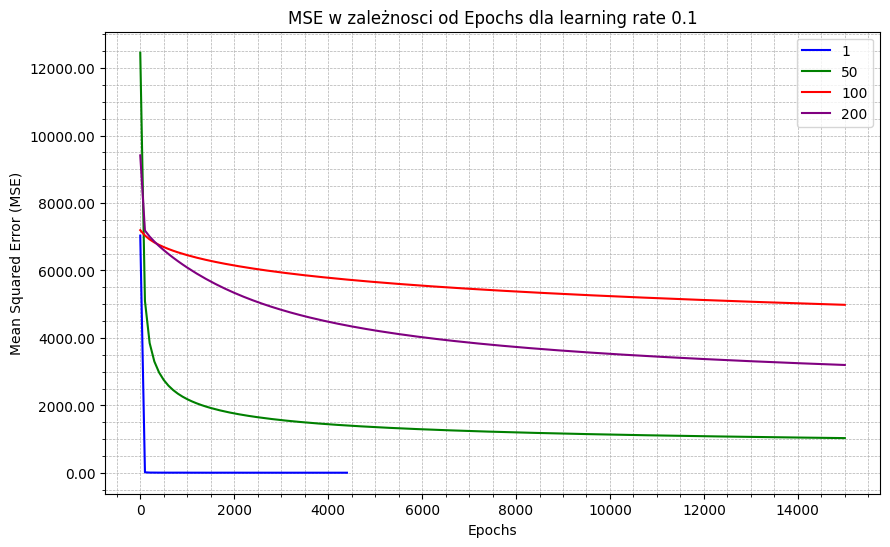

In [233]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_mse(datasets, labels, colors):
    """
    Plots MSE over epochs for given datasets with denser axes.
    
    Parameters:
    - datasets: List of Pandas DataFrames, each containing 'Epoch' and 'MSE' columns.
    - labels: List of labels for the datasets, for the legend.
    - colors: List of colors for the datasets.
    """
    plt.figure(figsize=(10, 6))
    
    ax = plt.gca()  # Get the current Axes instance on the current figure matching the given keyword args, or create one.
    
    for df, label, color in zip(datasets, labels, colors):
        plt.plot(df['Epoch'], df['MSE'], label=label, color=color)
    
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('MSE w zależnosci od Epochs dla learning rate 0.1')
    
    # Set denser x-axis and y-axis
    ax.xaxis.set_major_locator(ticker.AutoLocator())  # Automatically determine the tick locations
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())  # Subdivisions of the major ticks
    ax.yaxis.set_major_locator(ticker.AutoLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    
    # Optionally, you can format tick labels for readability, e.g., limiting the decimal places for MSE
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    
    plt.legend()
    plt.grid(visible=True, which='both', axis='both', linestyle='--', linewidth=0.5)  # Enhanced grid visibility
    plt.show()

# Assuming mse1_01, mse50_01, mse100_01, mse200_01 are your datasets as DataFrames
datasets = [mse1_01, mse50_01, mse100_01, mse200_01]
labels = ['1', '50', '100', '200']
colors = ['blue', 'green', 'red', 'purple']

plot_mse(datasets, labels, colors)


In [235]:
mse1_04 = list_to_dataframe(mse1_04)
mse50_04 = list_to_dataframe(mse50_04)
mse100_04 = list_to_dataframe(mse100_04)
mse200_04 = list_to_dataframe(mse200_04)

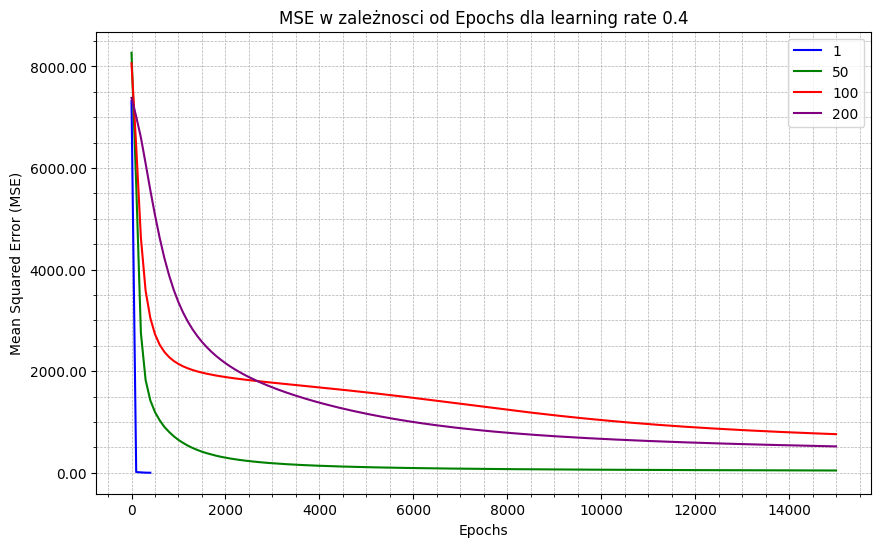

In [236]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_mse(datasets, labels, colors):
    """
    Plots MSE over epochs for given datasets with denser axes.
    
    Parameters:
    - datasets: List of Pandas DataFrames, each containing 'Epoch' and 'MSE' columns.
    - labels: List of labels for the datasets, for the legend.
    - colors: List of colors for the datasets.
    """
    plt.figure(figsize=(10, 6))
    
    ax = plt.gca()  # Get the current Axes instance on the current figure matching the given keyword args, or create one.
    
    for df, label, color in zip(datasets, labels, colors):
        plt.plot(df['Epoch'], df['MSE'], label=label, color=color)
    
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('MSE w zależnosci od Epochs dla learning rate 0.4')
    
    # Set denser x-axis and y-axis
    ax.xaxis.set_major_locator(ticker.AutoLocator())  # Automatically determine the tick locations
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())  # Subdivisions of the major ticks
    ax.yaxis.set_major_locator(ticker.AutoLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    
    # Optionally, you can format tick labels for readability, e.g., limiting the decimal places for MSE
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    
    plt.legend()
    plt.grid(visible=True, which='both', axis='both', linestyle='--', linewidth=0.5)  # Enhanced grid visibility
    plt.show()

# Assuming mse1_01, mse50_01, mse100_01, mse200_01 are your datasets as DataFrames
datasets = [mse1_04, mse50_04, mse100_04, mse200_04]
labels = ['1', '50', '100', '200']
colors = ['blue', 'green', 'red', 'purple']

plot_mse(datasets, labels, colors)


In [296]:
mse1_001 = list_to_dataframe(mse1_001)
mse50_001 = list_to_dataframe(mse50_001)
mse100_001 = list_to_dataframe(mse100_001)
mse200_001 = list_to_dataframe(mse200_001)

In [295]:
mse1_001

,Epoch,MSE
0,0,7595.808590
1,100,1362.179765
2,200,269.352503
3,300,178.399504
4,400,133.220609
...,...,...
146,14600,19.799071
147,14700,19.763531
148,14800,19.729740
149,14900,19.698862


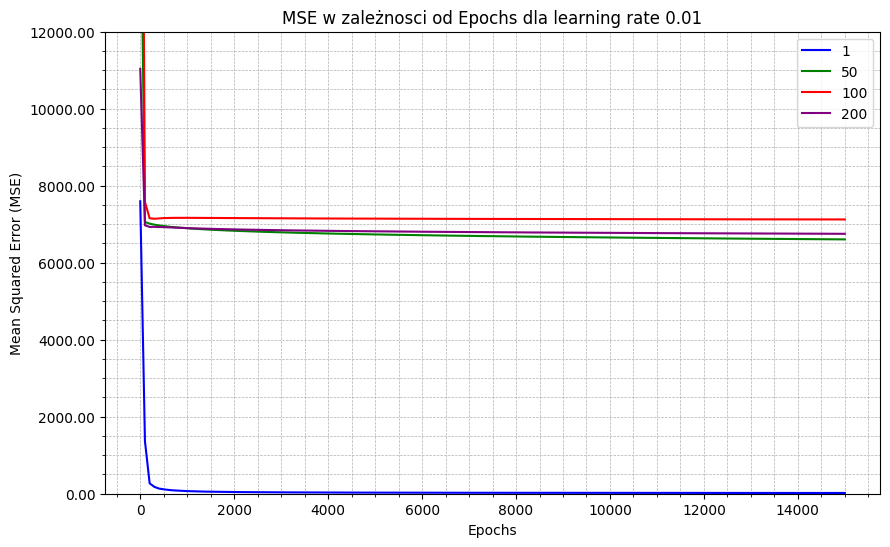

In [297]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_mse(datasets, labels, colors):
    """
    Plots MSE over epochs for given datasets with denser axes.
    
    Parameters:
    - datasets: List of Pandas DataFrames, each containing 'Epoch' and 'MSE' columns.
    - labels: List of labels for the datasets, for the legend.
    - colors: List of colors for the datasets.
    """
    plt.figure(figsize=(10, 6))
    
    ax = plt.gca()  # Get the current Axes instance on the current figure matching the given keyword args, or create one.
    
    for df, label, color in zip(datasets, labels, colors):
        plt.plot(df['Epoch'], df['MSE'], label=label, color=color)
    
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('MSE w zależnosci od Epochs dla learning rate 0.01')
    
    # Set denser x-axis and y-axis
    ax.xaxis.set_major_locator(ticker.AutoLocator())  # Automatically determine the tick locations
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())  # Subdivisions of the major ticks
    ax.yaxis.set_major_locator(ticker.AutoLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    
    ax.set_ylim(bottom=0, top=12000)
    
    # Optionally, you can format tick labels for readability, e.g., limiting the decimal places for MSE
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    
    plt.legend()
    plt.grid(visible=True, which='both', axis='both', linestyle='--', linewidth=0.5)  # Enhanced grid visibility
    plt.show()

# Assuming mse1_01, mse50_01, mse100_01, mse200_01 are your datasets as DataFrames
datasets = [mse1_001, mse50_001, mse100_001, mse200_001]
labels = ['1', '50', '100', '200']
colors = ['blue', 'green', 'red', 'purple']

plot_mse(datasets, labels, colors)


#### testing

#### testing

In [579]:
# Scale the test data using the transform method
X_test_scaled = scaler_X.transform(X_test_square_simple)

In [254]:
# Generate predictions on the scaled test data
predictions_scaled = np.array(
    [mlp_square_1_5.feedforward(x.reshape(-1, 1))[0] for x in X_test_scaled]
)

In [255]:
# Correctly denormalize predictions
predictions = scaler_y.inverse_transform(predictions_scaled.reshape(-1, 1))

# Calculate MSE score
for i in range(len(predictions)):
    print("predicted value: ",  predictions[i], "actual value: ", y_test_square_simple[i])
mse_score = mse(predictions, y_test_square_simple)

print(f"MSE Score: {mse_score}")

predicted value:  [14.65019097] actual value:  [-43.4869178]
predicted value:  [14.50990143] actual value:  [3.7528081]
predicted value:  [15.38282115] actual value:  [-128.61072132]
predicted value:  [15.88174534] actual value:  [5.67182845]
predicted value:  [15.80483908] actual value:  [-27.46916942]
predicted value:  [15.95083647] actual value:  [36.53905322]
predicted value:  [14.69847935] actual value:  [-56.38035958]
predicted value:  [16.21679778] actual value:  [163.71667642]
predicted value:  [14.99539213] actual value:  [-109.92253645]
predicted value:  [14.65155873] actual value:  [-43.87280887]
predicted value:  [15.78246282] actual value:  [-36.76289151]
predicted value:  [15.07044461] actual value:  [-117.96377078]
predicted value:  [15.88076443] actual value:  [5.24004298]
predicted value:  [15.23670684] actual value:  [-128.71571315]
predicted value:  [15.72082463] actual value:  [-61.08193105]
predicted value:  [15.87554309] actual value:  [2.94504249]
predicted value

In [103]:
# mse < 4, zalozenie spelnione

### steps-small dataset

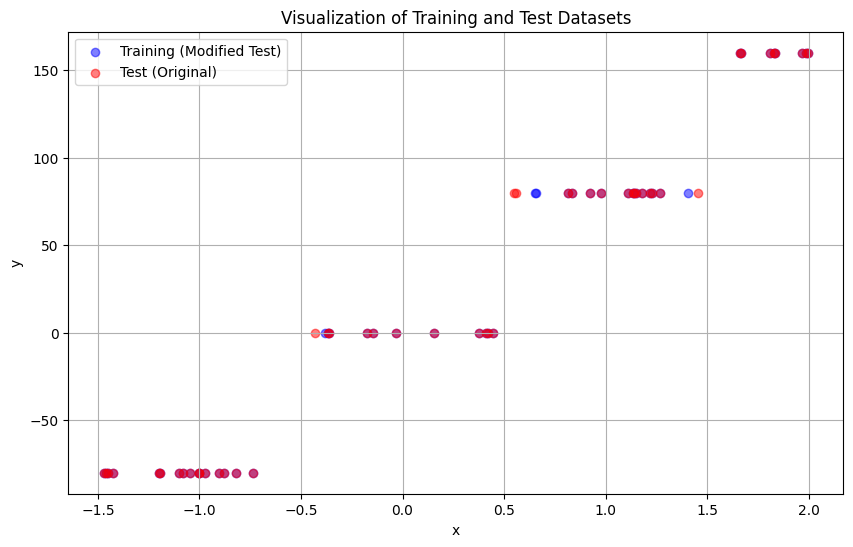

In [299]:
# Load the new datasets
test_mod_df = pd.read_csv('./data/regression/steps-small-test-mod.csv')
test_orig_df = pd.read_csv('./data/regression/steps-small-test.csv')

# Plotting the two datasets
plt.figure(figsize=(10, 6))

# Plot modified test data
plt.scatter(test_mod_df['x'], test_mod_df['y'], color='blue', label='Training (Modified Test)', alpha=0.5)

# Plot original test data
plt.scatter(test_orig_df['x'], test_orig_df['y'], color='red', label='Test (Original)', alpha=0.5)

plt.title('Visualization of Training and Test Datasets')
plt.xlabel('x')
plt.ylabel('y')

plt.grid(True)

plt.legend()
plt.show()


In [728]:
df_train_steps_small = pd.read_csv("data/regression/steps-large-test.csv")

In [729]:
scaler_X = DataScaler(method="standardization")
scaler_y = DataScaler(method="standardization")


In [730]:
df_test_steps_small = pd.read_csv("data/regression/steps-small-test-mod.csv")

X_test_steps_small = df_test_steps_small["x"].values.reshape(-1, 1)
y_test_steps_small = df_test_steps_small["y"].values.reshape(-1, 1)

In [731]:
mlp_steps = MLP([1, 5, 5, 1])

[array([[-2.07864009],
       [ 1.81270523],
       [-1.01160281],
       [-1.05731725],
       [-0.24207853]]), array([[ 0.45950963, -0.61979121, -0.31911812,  0.22710753,  0.40364458],
       [-0.4512433 , -0.71083707,  0.03594847, -0.23329336,  0.72903466],
       [-0.3734186 ,  0.15827711,  0.30334887, -0.63389707,  0.18834408],
       [ 0.14109486, -0.1098492 ,  0.02815431,  0.33044806,  0.18199115],
       [ 0.26373106,  0.23256392,  0.39335411, -0.40641455,  0.35031866]]), array([[-0.08917179, -0.82172212,  0.32744821,  0.44940783, -0.52043183]])]


In [732]:
# Fit and transform the training data
X_train_scaled2 = scaler_X.fit_transform(X_train_steps_small)
y_train_scaled2 = scaler_y.fit_transform(y_train_steps_small)


In [733]:
# Fit and transform the training data
X_test_scaled2 = scaler_X.transform(X_test_steps_small)
y_test_scaled2 = scaler_y.transform(y_test_steps_small)

In [734]:
training_data_scaled2 = [
    (x.reshape(-1, 1), y) for x, y in zip(X_train_scaled2, y_train_scaled2)
]

In [746]:
mlp_steps = MLP([1, 5, 5, 1])

[array([[ 1.53313017],
       [-1.41431096],
       [ 0.92655555],
       [-2.57375473],
       [-0.48739388]]), array([[-0.16154068, -0.89199982,  0.3230195 ,  0.48787725,  0.30574408],
       [-0.02548042,  1.08392514, -0.63419584, -0.328323  , -0.45317226],
       [-0.16437598, -0.00190643,  0.60304848, -0.68754689,  0.76605468],
       [ 0.45652788,  0.1926937 , -0.41273113, -0.0576418 ,  0.15617186],
       [ 0.42415124, -0.44901387, -0.04198799, -0.33764204,  0.39255558]]), array([[-0.03243308,  0.02715438,  0.28515816, -0.33881016, -0.54010287]])]


In [745]:
mse1_batch = mlp_steps.train(
    training_data_scaled2, epochs=15000, learning_rate=0.1, batch_size=1,
    X_val_scaled=X_test_scaled2, y_val_scaled=y_test_scaled2, X_val=X_test_steps_small, y_val=y_test_steps_small,
    scaler_X=scaler_X, scaler_y=scaler_y, mse_limit=4, update_method='batch'
)

Epoch 0, MSE: 6563.595096961292
Epoch 100, MSE: 384.06423511725984
Epoch 200, MSE: 349.82157112271756
Epoch 300, MSE: 364.0653258408884
Epoch 400, MSE: 361.91203499498823
Epoch 500, MSE: 357.73422951846527
Epoch 600, MSE: 359.1733998246236
Epoch 700, MSE: 356.73000613493844
Epoch 800, MSE: 368.9468381229548
Epoch 900, MSE: 373.36176625222123
Epoch 1000, MSE: 362.0728973674741
Epoch 1100, MSE: 349.30240934859825
Epoch 1200, MSE: 364.08539483102606
Epoch 1300, MSE: 352.57055520153466
Epoch 1400, MSE: 355.0420347417657
Epoch 1500, MSE: 371.2658655944765
Epoch 1600, MSE: 356.5873508221759
Epoch 1700, MSE: 356.17894856563447
Epoch 1800, MSE: 366.52480010279606
Epoch 1900, MSE: 353.6183862617873
Epoch 2000, MSE: 364.6402291717506
Epoch 2100, MSE: 360.5161825654468
Epoch 2200, MSE: 358.9264823922517
Epoch 2300, MSE: 362.1104907636351
Epoch 2400, MSE: 359.10759578967406
Epoch 2500, MSE: 362.39110703207655
Epoch 2600, MSE: 361.6342689341956
Epoch 2700, MSE: 361.8396888785964
Epoch 2800, MSE: 35

In [747]:
mse1_epoch = mlp_steps.train(
    training_data_scaled2, epochs=15000, learning_rate=0.1, batch_size=1,
    X_val_scaled=X_test_scaled2, y_val_scaled=y_test_scaled2, X_val=X_test_steps_small, y_val=y_test_steps_small,
    scaler_X=scaler_X, scaler_y=scaler_y, mse_limit=4, update_method='epoch'
)

Epoch 0, MSE: 8547.230065466445
Epoch 100, MSE: 6578.579692648966
Epoch 200, MSE: 5272.565451167479
Epoch 300, MSE: 3912.7428653049924
Epoch 400, MSE: 2803.061613538683
Epoch 500, MSE: 2031.6434300793753
Epoch 600, MSE: 1536.985786900708
Epoch 700, MSE: 1229.193342045862
Epoch 800, MSE: 1038.013133049303
Epoch 900, MSE: 917.7035925904506
Epoch 1000, MSE: 840.4299417741809
Epoch 1100, MSE: 789.599385481045
Epoch 1200, MSE: 755.307312281039
Epoch 1300, MSE: 731.5703949689787
Epoch 1400, MSE: 714.7124796663007
Epoch 1500, MSE: 702.4316841126127
Epoch 1600, MSE: 693.2582785328974
Epoch 1700, MSE: 686.2356523364921
Epoch 1800, MSE: 680.7295263518051
Epoch 1900, MSE: 676.3118448756469
Epoch 2000, MSE: 672.6888439065151
Epoch 2100, MSE: 669.655696963301
Epoch 2200, MSE: 667.0674278438194
Epoch 2300, MSE: 664.8199498244442
Epoch 2400, MSE: 662.8375131625668
Epoch 2500, MSE: 661.0642723843943
Epoch 2600, MSE: 659.4585422104507
Epoch 2700, MSE: 657.9888333517268
Epoch 2800, MSE: 656.631082622259

In [748]:
mse1_batch = list_to_dataframe(mse1_batch)
mse1_epoch = list_to_dataframe(mse1_epoch)

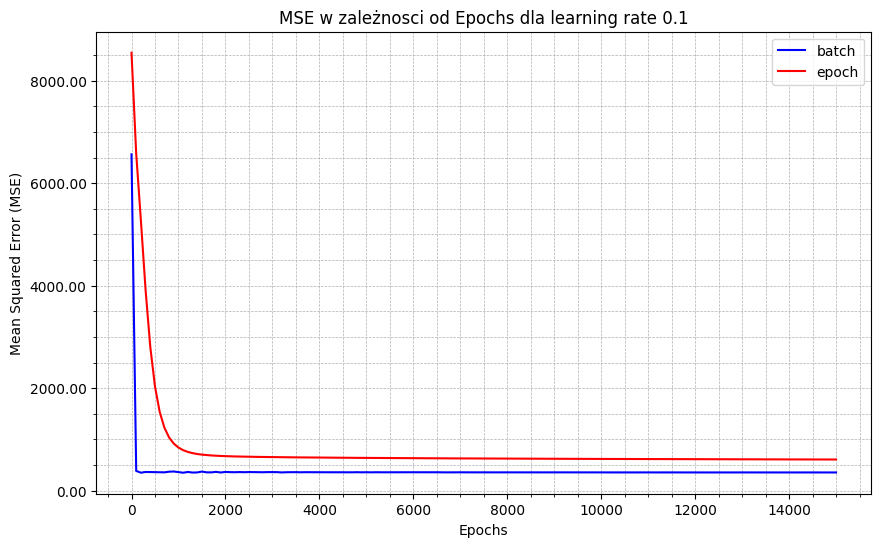

In [750]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_mse(datasets, labels, colors):
    """
    Plots MSE over epochs for given datasets with denser axes.
    
    Parameters:
    - datasets: List of Pandas DataFrames, each containing 'Epoch' and 'MSE' columns.
    - labels: List of labels for the datasets, for the legend.
    - colors: List of colors for the datasets.
    """
    plt.figure(figsize=(10, 6))
    
    ax = plt.gca()  # Get the current Axes instance on the current figure matching the given keyword args, or create one.
    
    for df, label, color in zip(datasets, labels, colors):
        plt.plot(df['Epoch'], df['MSE'], label=label, color=color)
    
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('MSE w zależnosci od Epochs dla learning rate 0.1')
    
    # Set denser x-axis and y-axis
    ax.xaxis.set_major_locator(ticker.AutoLocator())  # Automatically determine the tick locations
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())  # Subdivisions of the major ticks
    ax.yaxis.set_major_locator(ticker.AutoLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    
    # Optionally, you can format tick labels for readability, e.g., limiting the decimal places for MSE
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    
    plt.legend()
    plt.grid(visible=True, which='both', axis='both', linestyle='--', linewidth=0.5)  # Enhanced grid visibility
    plt.show()

# Assuming mse1_01, mse50_01, mse100_01, mse200_01 are your datasets as DataFrames
datasets = [mse1_batch, mse1_epoch]
labels = ['batch', 'epoch']
colors = ['blue', 'red']

plot_mse(datasets, labels, colors)


In [318]:
mlp_steps = MLP([1, 5, 5, 1])

[array([[ 0.70279549],
       [-0.70838215],
       [ 0.28355525],
       [-0.00323902],
       [-1.11776494]]), array([[-0.23947572,  0.02702006,  0.09005225,  0.31993029, -0.28441412],
       [ 0.26620701, -0.29195928,  0.59379091, -0.36989984,  0.62471866],
       [ 0.03992249, -0.13328173, -0.02997758, -1.24010771,  0.01876266],
       [ 0.20552016,  0.12579873, -0.16177612, -0.40111017, -0.58995674],
       [ 0.16950575,  0.31670721, -0.24689573,  0.05525571, -0.30863547]]), array([[-0.00908948,  0.18157072,  0.08918376,  0.23024624,  0.16070468]])]


In [319]:
mse50_001 = mlp_steps.train(
    training_data_scaled2, epochs=15000, learning_rate=0.01, batch_size=50,
    X_val_scaled=X_test_scaled2, y_val_scaled=y_test_scaled2, X_val=X_test_steps_small, y_val=y_test_steps_small,
    scaler_X=scaler_X, scaler_y=scaler_y, mse_limit=4
)

Epoch 0, MSE: 10065.581796820406
Epoch 100, MSE: 7488.066759507999
Epoch 200, MSE: 7426.032044488878
Epoch 300, MSE: 7435.6584640560695
Epoch 400, MSE: 7444.898612452113
Epoch 500, MSE: 7450.5801573324925
Epoch 600, MSE: 7453.798099324496
Epoch 700, MSE: 7455.49410417614
Epoch 800, MSE: 7456.25286656438
Epoch 900, MSE: 7456.425123458153
Epoch 1000, MSE: 7456.224178382034
Epoch 1100, MSE: 7455.782907956181
Epoch 1200, MSE: 7455.186148660672
Epoch 1300, MSE: 7454.489285075188
Epoch 1400, MSE: 7453.729171158064
Epoch 1500, MSE: 7452.930718243572
Epoch 1600, MSE: 7452.110973049134
Epoch 1700, MSE: 7451.281703513586
Epoch 1800, MSE: 7450.451074904995
Epoch 1900, MSE: 7449.624758047708
Epoch 2000, MSE: 7448.806675268998
Epoch 2100, MSE: 7447.999510587386
Epoch 2200, MSE: 7447.205063673721
Epoch 2300, MSE: 7446.424498566891
Epoch 2400, MSE: 7445.658520418765
Epoch 2500, MSE: 7444.907502348186
Epoch 2600, MSE: 7444.171577279535
Epoch 2700, MSE: 7443.450704928659
Epoch 2800, MSE: 7442.744720968

In [320]:
mlp_steps = MLP([1, 5, 5, 1])

[array([[-0.22879931],
       [-1.44773809],
       [ 1.80852404],
       [-1.35489028],
       [-1.27447822]]), array([[ 0.08154641, -0.31864081,  0.21376838,  0.73836939, -0.43053191],
       [ 0.40588559, -0.28913317,  1.22538756, -0.93955655, -0.6838235 ],
       [-0.63377978, -0.29419531,  0.13620712,  0.15884908,  0.37461699],
       [-0.3948173 , -0.12497004,  1.51440742, -0.56899927, -0.11763702],
       [ 0.02980452,  0.21546823, -0.74374743, -0.16774414,  0.99669725]]), array([[-0.36251276, -0.27566795,  0.35330711,  0.38069664,  0.56684684]])]


In [321]:
mse100_001 = mlp_steps.train(
    training_data_scaled2, epochs=15000, learning_rate=0.01, batch_size=100,
    X_val_scaled=X_test_scaled2, y_val_scaled=y_test_scaled2, X_val=X_test_steps_small, y_val=y_test_steps_small,
    scaler_X=scaler_X, scaler_y=scaler_y, mse_limit=4
)

Epoch 0, MSE: 12063.344341419173
Epoch 100, MSE: 7377.998934863293
Epoch 200, MSE: 6832.538166771328
Epoch 300, MSE: 6544.867982012436
Epoch 400, MSE: 6342.045184597403
Epoch 500, MSE: 6183.78117190898
Epoch 600, MSE: 6053.653244333358
Epoch 700, MSE: 5943.098257140684
Epoch 800, MSE: 5847.0088270328115
Epoch 900, MSE: 5762.06847987002
Epoch 1000, MSE: 5685.992458206108
Epoch 1100, MSE: 5617.136162772609
Epoch 1200, MSE: 5554.274784117558
Epoch 1300, MSE: 5496.4708955828055
Epoch 1400, MSE: 5442.990728333319
Epoch 1500, MSE: 5393.249006039804
Epoch 1600, MSE: 5346.771342024714
Epoch 1700, MSE: 5303.167865151906
Epoch 1800, MSE: 5262.114264469636
Epoch 1900, MSE: 5223.337874997995
Epoch 2000, MSE: 5186.607273462611
Epoch 2100, MSE: 5151.724370548178
Epoch 2200, MSE: 5118.518312657802
Epoch 2300, MSE: 5086.84071745277
Epoch 2400, MSE: 5056.56190745803
Epoch 2500, MSE: 5027.56790075882
Epoch 2600, MSE: 4999.757983138667
Epoch 2700, MSE: 4973.042731824538
Epoch 2800, MSE: 4947.342393638897

In [322]:
mlp_steps = MLP([1, 5, 5, 1])

[array([[ 1.32445209],
       [-0.51954576],
       [ 0.26041138],
       [ 0.28537513],
       [ 0.45312569]]), array([[ 0.30032321, -0.57638621, -0.47843866,  0.50717631,  0.10786526],
       [ 0.15832756,  0.65229206,  0.08674903, -0.23079554, -0.58186291],
       [ 0.51734181,  0.33582391,  0.01304961,  0.16738577, -0.62788456],
       [ 0.02974776,  1.01019175, -0.5576034 ,  0.256754  ,  0.0381631 ],
       [-0.10324543,  1.18483645,  0.70317848, -0.58657668, -0.23839613]]), array([[-0.36275385, -0.1381624 , -0.54386011,  0.59564399, -0.78678231]])]


In [323]:
mse1_001 = mlp_steps.train(
    training_data_scaled2, epochs=15000, learning_rate=0.01, batch_size=200,
    X_val_scaled=X_test_scaled2, y_val_scaled=y_test_scaled2, X_val=X_test_steps_small, y_val=y_test_steps_small,
    scaler_X=scaler_X, scaler_y=scaler_y, mse_limit=4
)

Epoch 0, MSE: 20522.691786182662
Epoch 100, MSE: 8036.322202551066
Epoch 200, MSE: 7432.327155420354
Epoch 300, MSE: 7270.001246331458
Epoch 400, MSE: 7185.956579899298
Epoch 500, MSE: 7128.740970301554
Epoch 600, MSE: 7084.540231816575
Epoch 700, MSE: 7048.041272339049
Epoch 800, MSE: 7016.687635206699
Epoch 900, MSE: 6989.052511783279
Epoch 1000, MSE: 6964.25327704633
Epoch 1100, MSE: 6941.701933929916
Epoch 1200, MSE: 6920.984540306254
Epoch 1300, MSE: 6901.797098288334
Epoch 1400, MSE: 6883.908806738669
Epoch 1500, MSE: 6867.139692919342
Epoch 1600, MSE: 6851.346313432537
Epoch 1700, MSE: 6836.41223573685
Epoch 1800, MSE: 6822.2414832474815
Epoch 1900, MSE: 6808.753889515019
Epoch 2000, MSE: 6795.881723244121
Epoch 2100, MSE: 6783.567183619857
Epoch 2200, MSE: 6771.760506548707
Epoch 2300, MSE: 6760.418509129708
Epoch 2400, MSE: 6749.503454564679
Epoch 2500, MSE: 6738.982155405534
Epoch 2600, MSE: 6728.825256798008
Epoch 2700, MSE: 6719.00665754077
Epoch 2800, MSE: 6709.50303798229

In [726]:
mlp_steps = MLP([1, 5, 5, 1])

[array([[-2.14533482],
       [-1.69499397],
       [ 0.25714994],
       [ 0.32163729],
       [ 0.82302573]]), array([[ 1.80920693e-01,  3.64011395e-01, -1.34186749e-01,
        -1.15227494e+00, -5.34863480e-01],
       [-5.30087186e-02, -1.22699215e-01,  2.61262154e-01,
        -9.30526364e-02, -1.13699637e+00],
       [-4.22282622e-02, -7.91278126e-01,  5.53719152e-01,
         3.79885571e-01, -2.80173100e-01],
       [-4.99744520e-01,  4.12348741e-01, -6.14208406e-04,
         3.02070813e-01, -2.29179827e-01],
       [ 1.60222078e-01, -4.99770437e-01,  5.16506870e-02,
         6.09330287e-01,  1.13825692e+00]]), array([[ 0.70758316,  0.68775679,  0.47131643,  0.30389632, -0.06175304]])]


In [727]:
mse1_01 = mlp_steps.train(
    training_data_scaled2, epochs=15000, learning_rate=0.1, batch_size=1,
    X_val_scaled=X_test_scaled2, y_val_scaled=y_test_scaled2, X_val=X_test_steps_small, y_val=y_test_steps_small,
    scaler_X=scaler_X, scaler_y=scaler_y, mse_limit=4
)

TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

In [334]:
mlp_steps = MLP([1, 5, 5, 1])

[array([[ 0.79873748],
       [-0.24489426],
       [ 0.65194487],
       [-0.66974151],
       [ 0.10164002]]), array([[-0.16453358,  0.11223856,  0.02232175, -0.84142648, -0.05308137],
       [-0.33153534,  0.29120173, -0.30208121, -0.52047074,  0.15017042],
       [-0.66856152,  0.80854007,  0.71162077,  0.2657316 ,  0.4870039 ],
       [-0.33389824,  0.11278256,  0.01016135,  0.02149117,  0.12625676],
       [ 0.65398456, -0.56079294, -0.21823623,  0.42559802,  0.15916752]]), array([[ 0.09788563, -0.64791677, -0.6992954 ,  0.29500516, -0.34303899]])]


In [335]:
mse50_01 = mlp_steps.train(
    training_data_scaled2, epochs=15000, learning_rate=0.1, batch_size=50,
    X_val_scaled=X_test_scaled2, y_val_scaled=y_test_scaled2, X_val=X_test_steps_small, y_val=y_test_steps_small,
    scaler_X=scaler_X, scaler_y=scaler_y, mse_limit=4
)

Epoch 0, MSE: 8409.902967739183
Epoch 100, MSE: 6850.391307482538
Epoch 200, MSE: 6095.0297494136585
Epoch 300, MSE: 5175.443417023682
Epoch 400, MSE: 4225.4092397178165
Epoch 500, MSE: 3372.3198096792844
Epoch 600, MSE: 2675.449427074285
Epoch 700, MSE: 2137.508409099534
Epoch 800, MSE: 1734.770438100602
Epoch 900, MSE: 1437.4551052175425
Epoch 1000, MSE: 1218.783218129976
Epoch 1100, MSE: 1057.540408246875
Epoch 1200, MSE: 937.8903467749577
Epoch 1300, MSE: 848.3462587882361
Epoch 1400, MSE: 780.6803866057422
Epoch 1500, MSE: 729.0194648145153
Epoch 1600, MSE: 689.1627639467805
Epoch 1700, MSE: 658.0903282342423
Epoch 1800, MSE: 633.6158110743123
Epoch 1900, MSE: 614.1435660907572
Epoch 2000, MSE: 598.4990049751939
Epoch 2100, MSE: 585.8098494114353
Epoch 2200, MSE: 575.4226040787535
Epoch 2300, MSE: 566.8434272648223
Epoch 2400, MSE: 559.6959661364042
Epoch 2500, MSE: 553.6910541541132
Epoch 2600, MSE: 548.604758144518
Epoch 2700, MSE: 544.2623455439476
Epoch 2800, MSE: 540.52648129

In [336]:
mlp_steps = MLP([1, 5, 5, 1])

[array([[-0.65683462],
       [-0.90146319],
       [ 0.52497104],
       [-0.94717744],
       [-0.73230901]]), array([[-0.05975784, -0.22525737, -0.97339679, -0.35094103,  0.00801833],
       [-0.32408781,  0.50928698,  0.01551336,  0.19539057,  0.04976506],
       [-0.18364776, -0.71726545,  0.21094973, -0.12994717, -0.22465697],
       [ 0.29091602, -0.19172758,  0.56658291,  0.29277854, -0.63838667],
       [ 1.10122224,  0.52678025,  0.23686185, -0.38206905, -0.07460592]]), array([[-0.35118617,  0.25953717, -0.21570871, -0.13825101, -0.41258297]])]


In [337]:
mse100_01 = mlp_steps.train(
    training_data_scaled2, epochs=15000, learning_rate=0.1, batch_size=100,
    X_val_scaled=X_test_scaled2, y_val_scaled=y_test_scaled2, X_val=X_test_steps_small, y_val=y_test_steps_small,
    scaler_X=scaler_X, scaler_y=scaler_y, mse_limit=4
)

Epoch 0, MSE: 11283.709899118163
Epoch 100, MSE: 6870.378441526932
Epoch 200, MSE: 6047.543294371932
Epoch 300, MSE: 5193.224200563655
Epoch 400, MSE: 4380.666620608393
Epoch 500, MSE: 3659.2953563309957
Epoch 600, MSE: 3048.173816336888
Epoch 700, MSE: 2546.111484804946
Epoch 800, MSE: 2141.5086482435836
Epoch 900, MSE: 1819.0343308777594
Epoch 1000, MSE: 1563.3679746811063
Epoch 1100, MSE: 1360.9161027510168
Epoch 1200, MSE: 1200.35343012616
Epoch 1300, MSE: 1072.577355071875
Epoch 1400, MSE: 970.4218091701646
Epoch 1500, MSE: 888.309486152247
Epoch 1600, MSE: 821.92349027134
Epoch 1700, MSE: 767.9279300043771
Epoch 1800, MSE: 723.7425132612562
Epoch 1900, MSE: 687.3660367279342
Epoch 2000, MSE: 657.2404755902578
Epoch 2100, MSE: 632.1472906388431
Epoch 2200, MSE: 611.128655975761
Epoch 2300, MSE: 593.4276854203362
Epoch 2400, MSE: 578.4430297236279
Epoch 2500, MSE: 565.6943050087928
Epoch 2600, MSE: 554.7956782675544
Epoch 2700, MSE: 545.435602823378
Epoch 2800, MSE: 537.36120171209

In [338]:
mlp_steps = MLP([1, 5, 5, 1])

[array([[ 1.31568428],
       [-0.36569326],
       [ 0.00563274],
       [ 1.48448385],
       [ 0.36799967]]), array([[-0.40766384, -0.0245136 , -0.61463831,  0.28379319, -0.11775672],
       [ 0.00992061, -0.90428222,  0.75619065,  0.18563552, -0.55362861],
       [ 0.24756524, -0.8201636 , -0.65137999,  0.16949802, -0.10237431],
       [ 0.22961401, -0.17770795,  0.14943824,  0.01152172, -0.2415532 ],
       [ 0.59199416,  0.64516912, -0.31252731, -0.0310186 , -0.52161376]]), array([[ 0.42468859, -0.11533698,  0.1050759 , -0.90730126, -0.21571105]])]


In [339]:
mse200_01 = mlp_steps.train(
    training_data_scaled2, epochs=15000, learning_rate=0.1, batch_size=200,
    X_val_scaled=X_test_scaled2, y_val_scaled=y_test_scaled2, X_val=X_test_steps_small, y_val=y_test_steps_small,
    scaler_X=scaler_X, scaler_y=scaler_y, mse_limit=4
)

Epoch 0, MSE: 9344.666413356228
Epoch 100, MSE: 6566.666744047268
Epoch 200, MSE: 5267.91320849475
Epoch 300, MSE: 4098.144875812019
Epoch 400, MSE: 3120.1542469393694
Epoch 500, MSE: 2368.8611661742734
Epoch 600, MSE: 1827.3622234219358
Epoch 700, MSE: 1451.1640886163996
Epoch 800, MSE: 1193.640594805594
Epoch 900, MSE: 1017.3709088677443
Epoch 1000, MSE: 895.6655620208409
Epoch 1100, MSE: 810.4888411439329
Epoch 1200, MSE: 749.9145335510879
Epoch 1300, MSE: 706.092418062764
Epoch 1400, MSE: 673.8311126241108
Epoch 1500, MSE: 649.6644225964244
Epoch 1600, MSE: 631.2497713389103
Epoch 1700, MSE: 616.9827637032588
Epoch 1800, MSE: 605.7494426251824
Epoch 1900, MSE: 596.7657795365039
Epoch 2000, MSE: 589.4725852834056
Epoch 2100, MSE: 583.4658907651237
Epoch 2200, MSE: 578.4502538697157
Epoch 2300, MSE: 574.2070517259167
Epoch 2400, MSE: 570.5726838055446
Epoch 2500, MSE: 567.4234084595013
Epoch 2600, MSE: 564.6646721118401
Epoch 2700, MSE: 562.223516619436
Epoch 2800, MSE: 560.043119431

In [332]:
mlp_steps = MLP([1, 5, 5, 1])

[array([[ 1.13988066],
       [-1.39945104],
       [ 0.02880828],
       [-0.47243602],
       [-1.524856  ]]), array([[ 0.19248436,  0.7944813 , -0.01432498,  0.37206199, -0.57623096],
       [-1.20071254, -0.02599001, -0.11230791, -0.04790959, -0.1733137 ],
       [ 0.14693187,  0.76479111, -0.43933937, -0.17434467, -0.24538907],
       [ 0.14898569,  0.46884094, -0.43402528, -0.17860728,  0.13742669],
       [-0.52153177, -0.59986715,  0.58544403, -0.27605081,  0.29020703]]), array([[ 0.80047569,  0.44626746, -0.30382452,  0.64431832, -1.23844422]])]


In [340]:
mse1_04 = mlp_steps.train(
    training_data_scaled2, epochs=15000, learning_rate=0.4, batch_size=1,
    X_val_scaled=X_test_scaled2, y_val_scaled=y_test_scaled2, X_val=X_test_steps_small, y_val=y_test_steps_small,
    scaler_X=scaler_X, scaler_y=scaler_y, mse_limit=4
)

Epoch 0, MSE: 548.4739339332796
Epoch 100, MSE: 309.55764270478176
Epoch 200, MSE: 393.36347163913956
Epoch 300, MSE: 339.5041683503421
Epoch 400, MSE: 316.66823366307887
Epoch 500, MSE: 411.4372428663431
Epoch 600, MSE: 309.8635293249454
Epoch 700, MSE: 411.1270148954479
Epoch 800, MSE: 306.83416109736675
Epoch 900, MSE: 336.2619456615391
Epoch 1000, MSE: 338.36272483064175
Epoch 1100, MSE: 319.6144536144378
Epoch 1200, MSE: 315.3461298592867
Epoch 1300, MSE: 341.4980777521489
Epoch 1400, MSE: 316.5484239586499
Epoch 1500, MSE: 336.58478370219177
Epoch 1600, MSE: 311.21735395793525
Epoch 1700, MSE: 318.7509554419106
Epoch 1800, MSE: 328.5973788895103
Epoch 1900, MSE: 316.3018521725751
Epoch 2000, MSE: 323.68176835057074
Epoch 2100, MSE: 317.3926678894327
Epoch 2200, MSE: 315.6316246920531
Epoch 2300, MSE: 304.35936325192887
Epoch 2400, MSE: 305.3728112678853
Epoch 2500, MSE: 301.9096032712283
Epoch 2600, MSE: 311.78235684728133
Epoch 2700, MSE: 308.1773618078342
Epoch 2800, MSE: 316.8

In [614]:
mlp_steps = MLP([1, 10, 5, 5, 1])

[array([[ 1.06190466],
       [ 0.2031133 ],
       [-0.37213864],
       [-0.2119353 ],
       [ 0.32699162],
       [-0.57463094],
       [ 0.39142281],
       [-2.42252882],
       [ 0.76915501],
       [-1.41960595]]), array([[-0.47839721,  0.10132763,  0.24284638,  0.36597474,  0.32951926,
        -0.40558006, -0.14760257,  0.49408923, -0.18407865,  0.08339636],
       [-0.15547333,  0.07655227,  0.16928039,  0.19005373,  0.34197722,
        -0.4839168 ,  0.46021027, -0.16172087, -0.07854579, -0.11737519],
       [-0.54546957,  0.60623563,  0.37228849, -0.39757774,  0.21759151,
        -0.08835607,  0.01849864,  0.11606845, -0.03650737, -0.20454014],
       [ 0.13166758,  0.03792964,  0.102947  , -0.05629868, -0.07297913,
        -0.20317202, -0.20459539, -0.46993448,  0.07904495, -0.53948053],
       [ 0.27717133, -0.3133809 , -0.18096046,  0.7501049 , -1.0090932 ,
         0.23801646, -0.19228431,  0.57112783,  0.18838774,  0.36730829]]), array([[-0.01478627,  0.84254984,  0.065

In [342]:
mse50_04 = mlp_steps.train(
    training_data_scaled2, epochs=15000, learning_rate=0.4, batch_size=50,
    X_val_scaled=X_test_scaled2, y_val_scaled=y_test_scaled2, X_val=X_test_steps_small, y_val=y_test_steps_small,
    scaler_X=scaler_X, scaler_y=scaler_y, mse_limit=4
)

Epoch 0, MSE: 7529.080162390317
Epoch 100, MSE: 689.1136958609688
Epoch 200, MSE: 559.8067330752534
Epoch 300, MSE: 524.4680923526075
Epoch 400, MSE: 503.36432991996816
Epoch 500, MSE: 489.24688538477415
Epoch 600, MSE: 479.01727504259804
Epoch 700, MSE: 471.1861149464818
Epoch 800, MSE: 464.949337511724
Epoch 900, MSE: 459.8329411285603
Epoch 1000, MSE: 455.5381395984662
Epoch 1100, MSE: 451.8664675025441
Epoch 1200, MSE: 448.6804476505999
Epoch 1300, MSE: 445.8815244408997
Epoch 1400, MSE: 443.3969972794842
Epoch 1500, MSE: 441.17192806708886
Epoch 1600, MSE: 439.1639356657855
Epoch 1700, MSE: 437.33973710160694
Epoch 1800, MSE: 435.67278404132117
Epoch 1900, MSE: 434.1416076880837
Epoch 2000, MSE: 432.72863450832324
Epoch 2100, MSE: 431.419322492376
Epoch 2200, MSE: 430.2015203442642
Epoch 2300, MSE: 429.06498471435015
Epoch 2400, MSE: 428.0010114233505
Epoch 2500, MSE: 427.00215019827107
Epoch 2600, MSE: 426.06198146536576
Epoch 2700, MSE: 425.17493985903224
Epoch 2800, MSE: 424.33

In [343]:
mlp_steps = MLP([1, 5, 5, 1])

[array([[-0.62421351],
       [ 0.77718306],
       [ 2.75609268],
       [ 1.73795337],
       [-0.59875349]]), array([[ 0.06768217,  0.73886975, -0.23815218, -0.4477381 ,  0.37813278],
       [ 0.62177187,  0.5640312 , -0.2150669 ,  0.15053002,  0.17814662],
       [ 0.88958475,  0.53465341,  0.37590812,  0.38992212,  0.01346755],
       [ 0.19713696,  0.19211679, -0.02206483, -0.00762477, -0.00962777],
       [ 0.31058583,  0.40166912, -0.0156972 , -0.40852316,  0.16657525]]), array([[ 0.41467726,  0.36908821, -0.33962532,  0.24668227, -0.15279915]])]


In [344]:
mse100_04 = mlp_steps.train(
    training_data_scaled2, epochs=15000, learning_rate=0.4, batch_size=100,
    X_val_scaled=X_test_scaled2, y_val_scaled=y_test_scaled2, X_val=X_test_steps_small, y_val=y_test_steps_small,
    scaler_X=scaler_X, scaler_y=scaler_y, mse_limit=4
)

Epoch 0, MSE: 8459.75755798855
Epoch 100, MSE: 6682.156619484965
Epoch 200, MSE: 1626.6402604142245
Epoch 300, MSE: 626.4937723822791
Epoch 400, MSE: 531.5239508628707
Epoch 500, MSE: 493.5826888406602
Epoch 600, MSE: 472.3415749418437
Epoch 700, MSE: 458.55667916598884
Epoch 800, MSE: 448.68834307324715
Epoch 900, MSE: 441.13627028260345
Epoch 1000, MSE: 435.08234356993984
Epoch 1100, MSE: 430.0651371320938
Epoch 1200, MSE: 425.8032279699611
Epoch 1300, MSE: 422.1139269152806
Epoch 1400, MSE: 418.8725433315477
Epoch 1500, MSE: 415.99044006340625
Epoch 1600, MSE: 413.40247145960006
Epoch 1700, MSE: 411.0594136789243
Epoch 1800, MSE: 408.9231994577876
Epoch 1900, MSE: 406.96380381383796
Epoch 2000, MSE: 405.15714186531585
Epoch 2100, MSE: 403.4836094673145
Epoch 2200, MSE: 401.9270449665357
Epoch 2300, MSE: 400.47397447438345
Epoch 2400, MSE: 399.11305269175085
Epoch 2500, MSE: 397.8346415466995
Epoch 2600, MSE: 396.63048784168836
Epoch 2700, MSE: 395.49347327307294
Epoch 2800, MSE: 394

In [345]:
mlp_steps = MLP([1, 5, 5, 1])

[array([[ 1.27863095],
       [-0.07673436],
       [-1.72632766],
       [ 1.10506824],
       [-1.48985262]]), array([[-0.17937402,  0.280891  ,  0.33903845,  0.55993812,  0.06506961],
       [-0.00888169,  0.7602082 , -0.57207185, -0.30962007,  0.21512118],
       [ 0.55588593,  0.41007054, -0.02646763,  0.15586858, -0.79672957],
       [-0.04719403,  0.43833601, -0.63044707, -0.36969078, -0.52324627],
       [ 0.23781851,  0.43039025,  0.00095541, -0.04527878, -0.51564108]]), array([[ 0.01566971, -0.19059233,  0.33171175, -0.75484858,  0.19946867]])]


In [346]:
mse200_04 = mlp_steps.train(
    training_data_scaled2, epochs=15000, learning_rate=0.4, batch_size=200,
    X_val_scaled=X_test_scaled2, y_val_scaled=y_test_scaled2, X_val=X_test_steps_small, y_val=y_test_steps_small,
    scaler_X=scaler_X, scaler_y=scaler_y, mse_limit=4
)

Epoch 0, MSE: 8623.096588377412
Epoch 100, MSE: 922.7285051078857
Epoch 200, MSE: 735.0645792416541
Epoch 300, MSE: 662.5520681547982
Epoch 400, MSE: 621.1435900099656
Epoch 500, MSE: 594.1287293010462
Epoch 600, MSE: 574.8617299442377
Epoch 700, MSE: 560.2624116261748
Epoch 800, MSE: 548.7133385045254
Epoch 900, MSE: 539.2814933664824
Epoch 1000, MSE: 531.3886035143411
Epoch 1100, MSE: 524.655546276714
Epoch 1200, MSE: 518.8223336750679
Epoch 1300, MSE: 513.7040178977946
Epoch 1400, MSE: 509.16497353568064
Epoch 1500, MSE: 505.10317156876516
Epoch 1600, MSE: 501.4401710677267
Epoch 1700, MSE: 498.1145282981745
Epoch 1800, MSE: 495.07732625942464
Epoch 1900, MSE: 492.28906340094187
Epoch 2000, MSE: 489.7174387408711
Epoch 2100, MSE: 487.33574323974943
Epoch 2200, MSE: 485.12167046879085
Epoch 2300, MSE: 483.05642312474345
Epoch 2400, MSE: 481.1240320749953
Epoch 2500, MSE: 479.31083058005805
Epoch 2600, MSE: 477.6050435001567
Epoch 2700, MSE: 475.9964628556263
Epoch 2800, MSE: 474.4761

In [619]:
mlp_steps = MLP([1, 10, 5, 5, 1])

[array([[ 0.09854937],
       [-1.43641448],
       [ 0.25421142],
       [-0.21868811],
       [ 0.35556163],
       [ 0.53701198],
       [ 0.8783834 ],
       [ 0.61555572],
       [ 1.60299973],
       [-0.41833871]]), array([[ 0.01717341,  0.10574675, -0.04028995, -0.6989646 ,  0.36283918,
         0.40863942, -0.27516812,  0.13765818,  0.02016727, -0.06873164],
       [-0.26159905,  0.71576629,  0.01136001, -0.25878411, -0.0067022 ,
        -0.32213308, -0.37459288,  0.48128559,  0.01183589,  0.14419109],
       [-0.19280816,  0.1894451 ,  0.06149058,  0.04882225,  0.1305733 ,
         0.17922937,  0.22855467,  0.18914155, -0.12769418,  0.07604057],
       [ 0.82815774,  0.37815906,  0.14919585,  0.38234995, -0.32288485,
         0.12680267, -0.05827942, -0.22898693,  0.01877184,  0.06975715],
       [-0.15010815, -0.10835941,  0.25680631, -0.15207762, -0.17267956,
        -0.02479239,  0.17638099,  0.02232506, -0.56919699, -0.20842944]]), array([[-0.60996262, -0.19539077,  0.095

In [620]:
mse1_05 = mlp_steps.train(
    training_data_scaled2, epochs=100000, learning_rate=0.1, batch_size=1,
    X_val_scaled=X_test_scaled2, y_val_scaled=y_test_scaled2, X_val=X_test_steps_small, y_val=y_test_steps_small,
    scaler_X=scaler_X, scaler_y=scaler_y, mse_limit=4
)

Epoch 0, MSE: 11678.658048451027
Epoch 100, MSE: 406.33062826356615
Epoch 200, MSE: 372.789670311953
Epoch 300, MSE: 387.0930313097065
Epoch 400, MSE: 388.1997505840681
Epoch 500, MSE: 396.0312860408654
Epoch 600, MSE: 360.68411253300474
Epoch 700, MSE: 384.01108270953296
Epoch 800, MSE: 405.254718239734
Epoch 900, MSE: 394.9741097044756
Epoch 1000, MSE: 393.73742035347846
Epoch 1100, MSE: 345.2526794077327
Epoch 1200, MSE: 354.26448295648436
Epoch 1300, MSE: 346.06698174479504
Epoch 1400, MSE: 387.934109399611
Epoch 1500, MSE: 354.287635780942
Epoch 1600, MSE: 353.66251506463357
Epoch 1700, MSE: 363.5015618897755
Epoch 1800, MSE: 362.13641791574827
Epoch 1900, MSE: 382.18613081598863
Epoch 2000, MSE: 375.5924510538028
Epoch 2100, MSE: 361.2981461011474
Epoch 2200, MSE: 365.31402770603506
Epoch 2300, MSE: 365.52885145509606
Epoch 2400, MSE: 364.3033949831505
Epoch 2500, MSE: 358.6645758120818
Epoch 2600, MSE: 366.8414878824605
Epoch 2700, MSE: 369.32835833856916
Epoch 2800, MSE: 360.51

KeyboardInterrupt: 

In [598]:
mse1_05_b = mlp_steps.train(
    training_data_scaled2, epochs=50000, learning_rate=0.4, batch_size=1,
    X_val_scaled=X_test_scaled2, y_val_scaled=y_test_scaled2, X_val=X_test_steps_small, y_val=y_test_steps_small,
    scaler_X=scaler_X, scaler_y=scaler_y, mse_limit=4
)

Epoch 0, MSE: 163.92106679056062
Epoch 100, MSE: 36.33686729725046
Epoch 200, MSE: 38.53937926244705
Epoch 300, MSE: 46.934614087667185
Epoch 400, MSE: 37.24683780520461
Epoch 500, MSE: 35.90109402233738
Epoch 600, MSE: 34.2099770655817
Epoch 700, MSE: 32.07656478360654
Epoch 800, MSE: 35.57351640243276
Epoch 900, MSE: 36.82072261013643
Epoch 1000, MSE: 31.812113805460104
Epoch 1100, MSE: 30.90867043913368
Epoch 1200, MSE: 33.05655417954057
Epoch 1300, MSE: 31.903688753055153
Epoch 1400, MSE: 31.757447305341852
Epoch 1500, MSE: 30.423503256679133
Epoch 1600, MSE: 31.02324851290379
Epoch 1700, MSE: 29.624599950666106
Epoch 1800, MSE: 30.70435947983633
Epoch 1900, MSE: 31.045311609573396
Epoch 2000, MSE: 30.208489403197923
Epoch 2100, MSE: 30.32072439366985
Epoch 2200, MSE: 29.247419536691122
Epoch 2300, MSE: 29.15411931272392
Epoch 2400, MSE: 30.157254875874404
Epoch 2500, MSE: 30.49801483843562
Epoch 2600, MSE: 28.83965487709474
Epoch 2700, MSE: 29.03868790927315
Epoch 2800, MSE: 29.57

In [599]:
mse1_05_c = mlp_steps.train(
    training_data_scaled2, epochs=50000, learning_rate=0.4, batch_size=1,
    X_val_scaled=X_test_scaled2, y_val_scaled=y_test_scaled2, X_val=X_test_steps_small, y_val=y_test_steps_small,
    scaler_X=scaler_X, scaler_y=scaler_y, mse_limit=4
)

Epoch 0, MSE: 28.872936862260335
Epoch 100, MSE: 19.271968668601186
Epoch 200, MSE: 27.604037614702712
Epoch 300, MSE: 18.897621003999262
Epoch 400, MSE: 20.89336111585045
Epoch 500, MSE: 19.383622786605695
Epoch 600, MSE: 19.771663617805288
Epoch 700, MSE: 17.924774931396417
Epoch 800, MSE: 17.470694435455027
Epoch 900, MSE: 18.056819110087886
Epoch 1000, MSE: 18.176398077826526
Epoch 1100, MSE: 17.991230874423053
Epoch 1200, MSE: 17.64432927806941
Epoch 1300, MSE: 16.943453951132845
Epoch 1400, MSE: 18.412851121848053
Epoch 1500, MSE: 17.381929259159488
Epoch 1600, MSE: 17.219908584651826
Epoch 1700, MSE: 17.12210254047832
Epoch 1800, MSE: 17.743913919759763
Epoch 1900, MSE: 17.20800974297209
Epoch 2000, MSE: 16.90786622968073
Epoch 2100, MSE: 16.91906856961634
Epoch 2200, MSE: 16.925223845112875
Epoch 2300, MSE: 17.091111752573262
Epoch 2400, MSE: 17.072243922211122
Epoch 2500, MSE: 16.90477906672199
Epoch 2600, MSE: 16.66609981911005
Epoch 2700, MSE: 16.63559736997152
Epoch 2800, M

In [600]:
mse1_05_d = mlp_steps.train(
    training_data_scaled2, epochs=50000, learning_rate=0.4, batch_size=1,
    X_val_scaled=X_test_scaled2, y_val_scaled=y_test_scaled2, X_val=X_test_steps_small, y_val=y_test_steps_small,
    scaler_X=scaler_X, scaler_y=scaler_y, mse_limit=4
)

Epoch 0, MSE: 21.14378886705859
Epoch 100, MSE: 13.358697921401664
Epoch 200, MSE: 13.596886051036838
Epoch 300, MSE: 13.387190571525169
Epoch 400, MSE: 12.559722203973553
Epoch 500, MSE: 13.23655652050385
Epoch 600, MSE: 12.826063865350266
Epoch 700, MSE: 11.877265074390705
Epoch 800, MSE: 11.918924950302765
Epoch 900, MSE: 11.930495705563295
Epoch 1000, MSE: 11.719566061073106
Epoch 1100, MSE: 11.567740079380803
Epoch 1200, MSE: 11.393681852848085
Epoch 1300, MSE: 11.29051434937619
Epoch 1400, MSE: 11.350523179908977
Epoch 1500, MSE: 11.739470257045207
Epoch 1600, MSE: 11.273848512807671
Epoch 1700, MSE: 11.279757857516831
Epoch 1800, MSE: 11.192481617991007
Epoch 1900, MSE: 11.467811340690664
Epoch 2000, MSE: 11.394700056863512
Epoch 2100, MSE: 11.431259304438504
Epoch 2200, MSE: 11.311554660485237
Epoch 2300, MSE: 10.979487706765267
Epoch 2400, MSE: 11.112871836074865
Epoch 2500, MSE: 10.931725001551833
Epoch 2600, MSE: 11.08955132574139
Epoch 2700, MSE: 11.010476571927281
Epoch 28

In [601]:
mse1_05_e = mlp_steps.train(
    training_data_scaled2, epochs=50000, learning_rate=0.4, batch_size=1,
    X_val_scaled=X_test_scaled2, y_val_scaled=y_test_scaled2, X_val=X_test_steps_small, y_val=y_test_steps_small,
    scaler_X=scaler_X, scaler_y=scaler_y, mse_limit=4
)

Epoch 0, MSE: 19.273916984734367
Epoch 100, MSE: 9.560017521525218
Epoch 200, MSE: 8.295360420720746
Epoch 300, MSE: 8.141657237311959
Epoch 400, MSE: 9.185064249008219
Epoch 500, MSE: 9.415487191745514
Epoch 600, MSE: 8.757177914195115
Epoch 700, MSE: 9.066322196058671
Epoch 800, MSE: 9.078941274557197
Epoch 900, MSE: 8.494915755883971
Epoch 1000, MSE: 8.743697479460925
Epoch 1100, MSE: 8.94517456747764
Epoch 1200, MSE: 8.495187926026071
Epoch 1300, MSE: 8.445751446374262
Epoch 1400, MSE: 8.365324501839089
Epoch 1500, MSE: 8.69229265092696
Epoch 1600, MSE: 8.998403877008958
Epoch 1700, MSE: 8.634689681062818
Epoch 1800, MSE: 8.64817558118363
Epoch 1900, MSE: 8.531638410199918
Epoch 2000, MSE: 8.535675011301556
Epoch 2100, MSE: 8.431360161824681
Epoch 2200, MSE: 8.329613565444447
Epoch 2300, MSE: 8.538415098858534
Epoch 2400, MSE: 8.622351266348423
Epoch 2500, MSE: 8.511383146499849
Epoch 2600, MSE: 8.396518989522383
Epoch 2700, MSE: 8.484856683879812
Epoch 2800, MSE: 8.414431480835374

In [610]:
# Merge lists into one DataFrame
data = mse1_05 + mse1_05_b + mse1_05_c + mse1_05_d
df = pd.DataFrame(data, columns=['Epoch', 'MSE'])

# # Adjust the 'Epoch' column
# # Assuming each list represents a different dataset, and the epoch number should increase by 100 with each new dataset
# offsets = [i * 100 for i in range(5)]  # Adjust the multiplier based on the number of lists/data segments
# new_epochs = [epoch + offset for offset in offsets for epoch in range(100)]  # Generate new epoch values
# df['Epoch'] = new_epochs

df['Epoch'] = df.index * 100

df.head(), df.tail()



(   Epoch         MSE
 0      0  839.236215
 1    100  335.772369
 2    200  319.355381
 3    300  312.605267
 4    400  350.714319,
        Epoch       MSE
 2499  249900  9.114452
 2500  250000  9.113665
 2501  250100  9.111711
 2502  250200  9.110808
 2503  250300  9.107822)

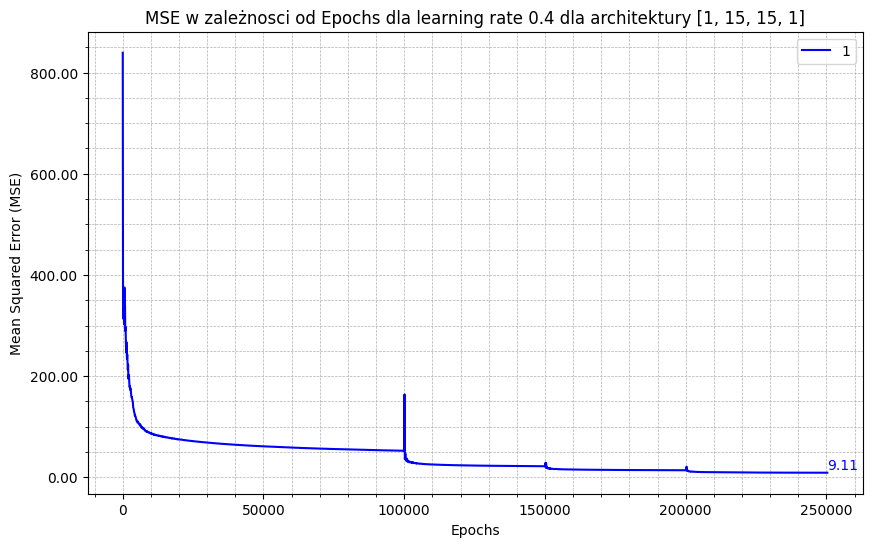

In [612]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_mse(datasets, labels, colors):
    """
    Plots MSE over epochs for given datasets with denser axes, and annotates the last MSE value.
    
    Parameters:
    - datasets: List of Pandas DataFrames, each containing 'Epoch' and 'MSE' columns.
    - labels: List of labels for the datasets, for the legend.
    - colors: List of colors for the datasets.
    """
    plt.figure(figsize=(10, 6))
    
    ax = plt.gca()
    
    for df, label, color in zip(datasets, labels, colors):
        plt.plot(df['Epoch'], df['MSE'], label=label, color=color)
        # Annotate the last MSE value
        final_epoch = df['Epoch'].iloc[-1]
        final_mse = df['MSE'].iloc[-1]
        plt.text(final_epoch, final_mse, f'{final_mse:.2f}', color=color, verticalalignment='bottom')
    
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('MSE w zależnosci od Epochs dla learning rate 0.4 dla architektury [1, 15, 15, 1]')
    
    ax.xaxis.set_major_locator(ticker.AutoLocator())
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_major_locator(ticker.AutoLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    
    plt.legend()
    plt.grid(visible=True, which='both', axis='both', linestyle='--', linewidth=0.5)
    plt.show()

# Assuming mse1_01, mse50_01, mse100_01, mse200_01 are your datasets as DataFrames
datasets = [df]  # Replace with actual DataFrames
labels = ['1']  # Customize as needed
colors = ['blue']  # Choose your preferred colors

plot_mse(datasets, labels, colors)


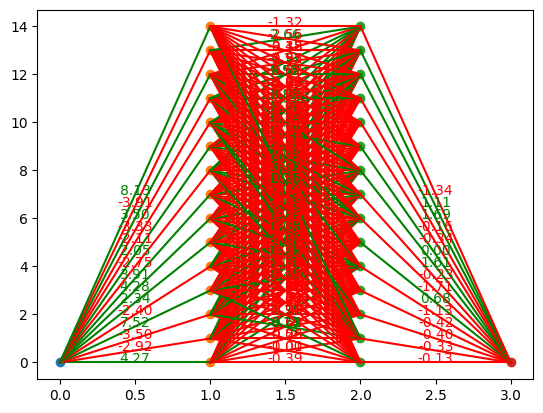

In [613]:
mlp_steps.visualize_network()

In [388]:
mse1_001 = list_to_dataframe(mse1_001)
mse50_001 = list_to_dataframe(mse50_001)
mse100_001 = list_to_dataframe(mse100_001)
mse200_001 = list_to_dataframe(mse200_001)

In [389]:
mse1_01 = list_to_dataframe(mse1_01)
mse50_01 = list_to_dataframe(mse50_01)
mse100_01 = list_to_dataframe(mse100_01)
mse200_01 = list_to_dataframe(mse200_01)

In [390]:
mse1_04 = list_to_dataframe(mse1_04)
mse50_04 = list_to_dataframe(mse50_04)
mse100_04 = list_to_dataframe(mse100_04)
mse200_04 = list_to_dataframe(mse200_04)

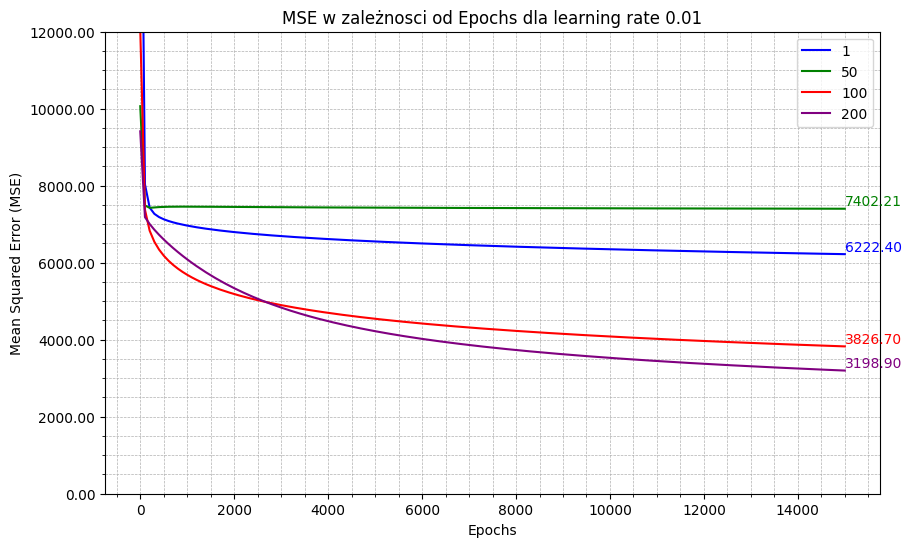

In [403]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_mse(datasets, labels, colors):
    """
    Plots MSE over epochs for given datasets with denser axes, and annotates the last MSE value.
    
    Parameters:
    - datasets: List of Pandas DataFrames, each containing 'Epoch' and 'MSE' columns.
    - labels: List of labels for the datasets, for the legend.
    - colors: List of colors for the datasets.
    """
    plt.figure(figsize=(10, 6))
    
    ax = plt.gca()
    
    for df, label, color in zip(datasets, labels, colors):
        plt.plot(df['Epoch'], df['MSE'], label=label, color=color)
        # Annotate the last MSE value
        final_epoch = df['Epoch'].iloc[-1]
        final_mse = df['MSE'].iloc[-1]
        plt.text(final_epoch, final_mse, f'{final_mse:.2f}', color=color, verticalalignment='bottom')
    
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('MSE w zależnosci od Epochs dla learning rate 0.01')
    
    ax.xaxis.set_major_locator(ticker.AutoLocator())
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_major_locator(ticker.AutoLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    
    ax.set_ylim(bottom=0, top=12000)
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    
    plt.legend()
    plt.grid(visible=True, which='both', axis='both', linestyle='--', linewidth=0.5)
    plt.show()

# Assuming mse1_01, mse50_01, mse100_01, mse200_01 are your datasets as DataFrames
datasets = [mse1_001, mse50_001, mse100_001, mse200_001]  # Replace with actual DataFrames
labels = ['1', '50', '100', '200']  # Customize as needed
colors = ['blue', 'green', 'red', 'purple']  # Choose your preferred colors

plot_mse(datasets, labels, colors)


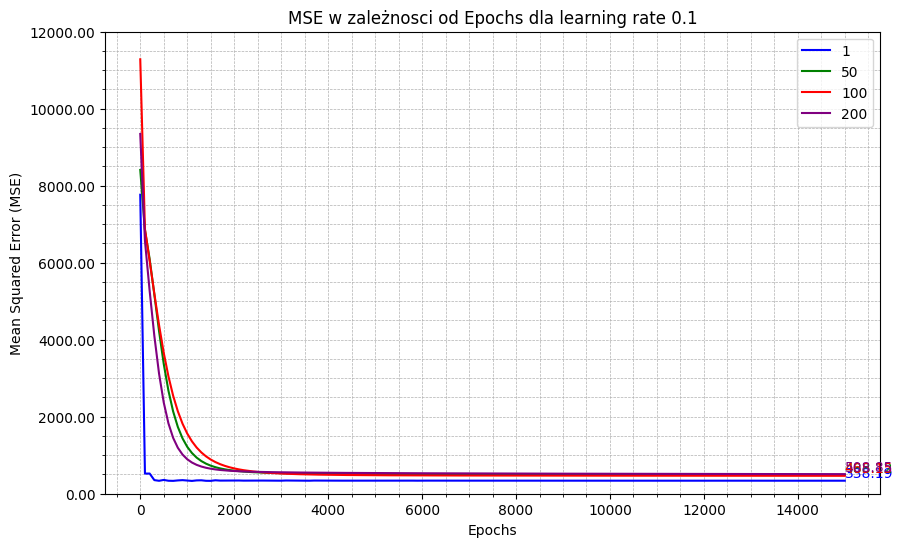

In [404]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_mse(datasets, labels, colors):
    """
    Plots MSE over epochs for given datasets with denser axes, and annotates the last MSE value.
    
    Parameters:
    - datasets: List of Pandas DataFrames, each containing 'Epoch' and 'MSE' columns.
    - labels: List of labels for the datasets, for the legend.
    - colors: List of colors for the datasets.
    """
    plt.figure(figsize=(10, 6))
    
    ax = plt.gca()
    
    for df, label, color in zip(datasets, labels, colors):
        plt.plot(df['Epoch'], df['MSE'], label=label, color=color)
        # Annotate the last MSE value
        final_epoch = df['Epoch'].iloc[-1]
        final_mse = df['MSE'].iloc[-1]
        plt.text(final_epoch, final_mse, f'{final_mse:.2f}', color=color, verticalalignment='bottom')
    
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('MSE w zależnosci od Epochs dla learning rate 0.1')
    
    ax.xaxis.set_major_locator(ticker.AutoLocator())
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_major_locator(ticker.AutoLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    
    ax.set_ylim(bottom=0, top=12000)
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    
    plt.legend()
    plt.grid(visible=True, which='both', axis='both', linestyle='--', linewidth=0.5)
    plt.show()

# Assuming mse1_01, mse50_01, mse100_01, mse200_01 are your datasets as DataFrames
datasets = [mse1_01, mse50_01, mse100_01, mse200_01]  # Replace with actual DataFrames
labels = ['1', '50', '100', '200']  # Customize as needed
colors = ['blue', 'green', 'red', 'purple']  # Choose your preferred colors

plot_mse(datasets, labels, colors)


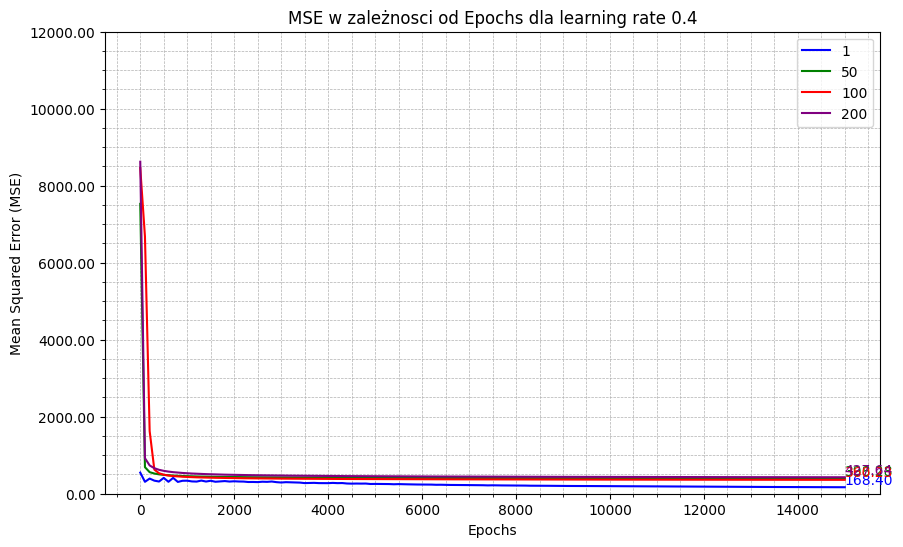

In [405]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_mse(datasets, labels, colors):
    """
    Plots MSE over epochs for given datasets with denser axes, and annotates the last MSE value.
    
    Parameters:
    - datasets: List of Pandas DataFrames, each containing 'Epoch' and 'MSE' columns.
    - labels: List of labels for the datasets, for the legend.
    - colors: List of colors for the datasets.
    """
    plt.figure(figsize=(10, 6))
    
    ax = plt.gca()
    
    for df, label, color in zip(datasets, labels, colors):
        plt.plot(df['Epoch'], df['MSE'], label=label, color=color)
        # Annotate the last MSE value
        final_epoch = df['Epoch'].iloc[-1]
        final_mse = df['MSE'].iloc[-1]
        plt.text(final_epoch, final_mse, f'{final_mse:.2f}', color=color, verticalalignment='bottom')
    
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('MSE w zależnosci od Epochs dla learning rate 0.4')
    
    ax.xaxis.set_major_locator(ticker.AutoLocator())
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_major_locator(ticker.AutoLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    
    ax.set_ylim(bottom=0, top=12000)
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    
    plt.legend()
    plt.grid(visible=True, which='both', axis='both', linestyle='--', linewidth=0.5)
    plt.show()

# Assuming mse1_01, mse50_01, mse100_01, mse200_01 are your datasets as DataFrames
datasets = [mse1_04, mse50_04, mse100_04, mse200_04]  # Replace with actual DataFrames
labels = ['1', '50', '100', '200']  # Customize as needed
colors = ['blue', 'green', 'red', 'purple']  # Choose your preferred colors

plot_mse(datasets, labels, colors)


In [313]:
def list_to_dataframe(lst):
    return pd.DataFrame(lst, columns=['Epoch', 'MSE'])

# Define batch sizes and learning rates to iterate over
batch_sizes = [1, 50, 100, 200]
learning_rates = [0.01, 0.1, 0.4, 0.7]

# Placeholder for MSE histories
mse_histories = []

for lr in learning_rates:
    for batch_size in batch_sizes:
        # Initialize the MLP
        mlp = MLP([1, 5, 5, 1])
        
        # Train the MLP
        mse_history = mlp.train(
            training_data=training_data_scaled2, epochs=15000, learning_rate=lr, batch_size=batch_size,
            X_val_scaled=X_test_scaled2, y_val_scaled=y_test_scaled2, X_val=X_test_steps_small, y_val=y_test_steps_small,
            scaler_X=scaler_X, scaler_y=scaler_y, mse_limit=4
        )
        
        # Convert the MSE history to a DataFrame and add to the list
        mse_histories.append(list_to_dataframe(mse_history))

# Plotting logic (assuming the plot_mse function is defined as above)
labels = [f'Batch {bs}, LR {lr}' for lr in learning_rates for bs in batch_sizes]
colors = ['blue', 'green', 'red', 'purple', 'orange', 'yellow', 'black', 'cyan']  # Extend as needed

plot_mse(datasets=mse_histories, labels=labels, colors=colors)

[array([[-0.94805097],
       [ 0.76114277],
       [-0.27220081],
       [ 0.78370823],
       [-1.19682643]]), array([[ 0.010873  ,  0.03197196, -0.51537266, -0.60074638,  0.02784827],
       [ 0.90358276, -0.23378171,  0.13512138, -0.70373719, -0.12808347],
       [ 0.25608475, -0.37312774, -1.19540905,  0.46950916,  0.04969897],
       [ 0.27371131, -0.28965249, -0.27914116,  0.17136276, -0.58477039],
       [ 0.6658581 ,  0.57743105, -0.01640974,  0.38476536,  0.77219729]]), array([[-0.39791533,  0.11566735,  0.06025179,  0.04437224, -0.02163936]])]
Epoch 0, MSE: 7766.607395625884
Epoch 100, MSE: 596.3591602445814
Epoch 200, MSE: 535.8665508252326
Epoch 300, MSE: 497.5936005661845
Epoch 400, MSE: 482.9400889547739
Epoch 500, MSE: 468.4952931776572
Epoch 600, MSE: 459.02914308137207
Epoch 700, MSE: 452.7782993442506
Epoch 800, MSE: 447.63432182329547
Epoch 900, MSE: 442.7623472333787
Epoch 1000, MSE: 438.9742310627051
Epoch 1100, MSE: 436.59647574751085
Epoch 1200, MSE: 433.4300215

KeyboardInterrupt: 

In [314]:
def list_to_dataframe(lst):
    return pd.DataFrame(lst, columns=['Epoch', 'MSE'])

# Define batch sizes and learning rates to iterate over
batch_sizes = [1, 50, 100, 200]
learning_rates = [0.01, 0.1, 0.4, 0.7]

# Train models and store MSE histories
for lr in learning_rates:
    mse_histories = []
    for batch_size in batch_sizes:
        # Initialize and train the MLP here
        # Assuming the training function returns a list of (epoch, MSE) tuples
        mse_history = mlp.train(
            training_data=training_data_scaled2, epochs=15000, learning_rate=lr, batch_size=batch_size,
            X_val_scaled=X_test_scaled2, y_val_scaled=y_test_scaled2, X_val=X_test_steps_small, y_val=y_test_steps_small,
            scaler_X=scaler_X, scaler_y=scaler_y, mse_limit=4
        )
        # Convert the MSE history to a DataFrame and store
        mse_histories.append(list_to_dataframe(mse_history))

    # Plotting for this learning rate
    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    
    labels = [f'Batch {bs}' for bs in batch_sizes]
    colors = ['blue', 'green', 'red', 'purple']  # Adjust as needed
    
    for df, label, color in zip(mse_histories, labels, colors):
        plt.plot(df['Epoch'], df['MSE'], label=label, color=color)

    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title(f'MSE over Epochs for Learning Rate {lr}')
    
    ax.xaxis.set_major_locator(ticker.AutoLocator())
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_major_locator(ticker.AutoLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.set_ylim(bottom=0, top=12000)
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    
    plt.legend()
    plt.grid(visible=True, which='both', axis='both', linestyle='--', linewidth=0.5)
    plt.show()

Epoch 0, MSE: 6250.508257935959
Epoch 100, MSE: 682.8677834899405
Epoch 200, MSE: 577.7606024369786
Epoch 300, MSE: 533.0876336799056
Epoch 400, MSE: 512.6780645526468
Epoch 500, MSE: 493.79916255089205
Epoch 600, MSE: 482.0375458824737
Epoch 700, MSE: 473.29381948897424
Epoch 800, MSE: 466.08346250670627
Epoch 900, MSE: 460.31693100658106
Epoch 1000, MSE: 455.7068870056022
Epoch 1100, MSE: 451.8064771312844
Epoch 1200, MSE: 448.2370570960039
Epoch 1300, MSE: 445.0085472777318
Epoch 1400, MSE: 442.7617165083653
Epoch 1500, MSE: 440.04092621124704
Epoch 1600, MSE: 438.0211336828885
Epoch 1700, MSE: 435.82075882592454
Epoch 1800, MSE: 434.2289368206402
Epoch 1900, MSE: 432.74702583554927
Epoch 2000, MSE: 431.20599033922025
Epoch 2100, MSE: 429.89274103443296
Epoch 2200, MSE: 428.6041715391008
Epoch 2300, MSE: 427.32261435812245
Epoch 2400, MSE: 426.2762093829523
Epoch 2500, MSE: 425.34480578717944
Epoch 2600, MSE: 424.28438064216965
Epoch 2700, MSE: 423.5056977138351
Epoch 2800, MSE: 422

KeyboardInterrupt: 

#### testing

In [307]:
# Scale the test data using the transform method
X_test_scaled2 = scaler_X.transform(X_test_steps_small)

In [308]:
# Generate predictions on the scaled test data
predictions_scaled2 = np.array(
    [mlp_steps.feedforward(x.reshape(-1, 1))[0] for x in X_test_scaled2]
)

In [309]:
# Correctly denormalize predictions
predictions2 = scaler_y.inverse_transform(predictions_scaled2.reshape(-1, 1))

# Calculate MSE score
for i in range(len(predictions2)):
    print("predicted value: ",  predictions2[i], "actual value: ", y_test_steps_small[i])
mse_score2 = mse(predictions2, y_test_steps_small)

print(f"MSE Score: {mse_score2}")

predicted value:  [-77.85854176] actual value:  [-80]
predicted value:  [90.96378095] actual value:  [80]
predicted value:  [-93.94139121] actual value:  [-80]
predicted value:  [-72.15144522] actual value:  [-80]
predicted value:  [-81.86096382] actual value:  [-80]
predicted value:  [19.57221521] actual value:  [0]
predicted value:  [22.46738675] actual value:  [0]
predicted value:  [-92.92863399] actual value:  [-80]
predicted value:  [-76.48869312] actual value:  [-80]
predicted value:  [26.10907592] actual value:  [0]
predicted value:  [91.34456592] actual value:  [80]
predicted value:  [61.45274065] actual value:  [80]
predicted value:  [94.75726702] actual value:  [80]
predicted value:  [-77.68258784] actual value:  [-80]
predicted value:  [45.75477541] actual value:  [80]
predicted value:  [76.51073661] actual value:  [80]
predicted value:  [-16.96225506] actual value:  [0]
predicted value:  [149.80194616] actual value:  [160]
predicted value:  [-85.4982727] actual value:  [-80

In [524]:
# nie ma optymalnego mse :((((

### multimodal-large dataset

In [753]:
# Initialize the scaler for X and y with the desired scaling method
scaler_X = DataScaler(method="standardization")
scaler_y = DataScaler(method="standardization")

In [754]:
mlp_multimodal = MLP([1, 10, 10, 1])

[array([[-0.9292649 ],
       [ 0.02696453],
       [-1.03282526],
       [ 1.81663791],
       [ 1.11891721],
       [-0.82964343],
       [ 2.31892697],
       [-2.18148939],
       [ 0.99607783],
       [-0.24285029]]), array([[ 0.27741441, -0.11472933, -0.12158146,  0.19106056,  0.12261169,
        -0.03787934,  0.24103014, -0.16300695,  0.34590699,  0.11447711],
       [ 0.03216285,  0.06573286, -0.42639357, -0.13896229, -0.82767497,
         0.4773924 ,  0.16376154,  0.25862802,  0.1597901 , -0.20942504],
       [-0.11811449, -0.30028455,  0.0478928 ,  0.03122413, -0.09543301,
         0.25970204, -0.13709531,  0.23091396, -0.19453948, -0.1268821 ],
       [-0.14458879,  0.05653176,  0.23811366, -0.67417538,  0.09164605,
        -0.00381047, -0.05572044, -0.30627186,  0.14870694,  0.24395973],
       [ 0.14452094, -0.01441435,  0.42264868,  0.75432592,  0.14964335,
         0.26620625, -0.21712064,  0.22196403, -0.4493475 ,  0.42498248],
       [-0.4664604 , -0.00922223, -0.40126

In [755]:
# Fit and transform the training data
X_train_scaled3 = scaler_X.fit_transform(X_train_multimodal_large)
y_train_scaled3 = scaler_y.fit_transform(y_train_multimodal_large)


In [756]:
X_test_scaled3 = scaler_X.transform(X_test_multimodal_large)
y_test_scaled3 = scaler_y.transform(y_test_multimodal_large)

In [757]:
training_data_scaled3 = [
    (x.reshape(-1, 1), y) for x, y in zip(X_train_scaled3, y_train_scaled3)
]

In [758]:
mse1_1 = mlp_multimodal.train(
    training_data_scaled3, epochs=5000, learning_rate=1, batch_size=1,
    X_val_scaled=X_test_scaled3, y_val_scaled=y_test_scaled3, X_val=X_test_multimodal_large, y_val=y_test_multimodal_large,
    scaler_X=scaler_X, scaler_y=scaler_y, mse_limit=40, visual_interval=10
)

Epoch 0, MSE: 1127.6281214801197
Epoch 10, MSE: 528.2850423700206
Epoch 20, MSE: 462.50421868365925


KeyboardInterrupt: 

In [669]:
mlp_multimodal = MLP([1, 10, 10, 1])


[array([[-1.78421059],
       [-0.13462177],
       [ 1.38359595],
       [ 0.35778212],
       [-0.53552566],
       [ 0.90837063],
       [ 0.48147174],
       [ 0.11286816],
       [ 1.33239126],
       [ 0.74653567]]), array([[ 0.32215593,  0.41456441, -0.20067125,  0.13513661,  0.1266774 ,
        -0.37081623, -0.05714763,  0.12805855,  0.55242214,  0.1028717 ],
       [-0.29800384, -0.02240199,  0.0763879 ,  0.26199805, -0.24021348,
         0.21510741,  0.04972546, -0.2107089 , -0.00726858,  0.11908784],
       [ 0.63461484,  0.52940325, -0.89201502,  0.30862219,  0.20236914,
         0.75287299, -0.04882559,  0.15196067,  0.48257481, -0.31937659],
       [-0.60772847,  0.11567819, -0.49414624, -0.8156503 ,  0.02673399,
        -0.46824137, -0.36145901, -0.18607117,  0.35944291, -0.42036085],
       [ 0.25725232,  0.55485757, -0.01051503,  0.3149678 ,  0.05345166,
         0.09339874, -0.26215831,  0.68150397, -0.15160965, -0.266268  ],
       [ 0.08124133, -0.13862029,  0.50767

In [670]:
mse50_1 = mlp_multimodal.train(
    training_data_scaled3, epochs=500, learning_rate=1, batch_size=50,
    X_val_scaled=X_test_scaled3, y_val_scaled=y_test_scaled3, X_val=X_test_multimodal_large, y_val=y_test_multimodal_large,
    scaler_X=scaler_X, scaler_y=scaler_y, mse_limit=40, visual_interval=10
)

Epoch 0, MSE: 3394.696026408142
Epoch 10, MSE: 622.6039828134726
Epoch 20, MSE: 597.0245154917035
Epoch 30, MSE: 466.66404483300494
Epoch 40, MSE: 480.6901120331132
Epoch 50, MSE: 476.0753873722313
Epoch 60, MSE: 455.317541556744
Epoch 70, MSE: 443.49078452889904
Epoch 80, MSE: 425.65537723354043
Epoch 90, MSE: 441.4379037891517
Epoch 100, MSE: 435.08860596844147
Epoch 110, MSE: 394.180042438027
Epoch 120, MSE: 356.5287421940286
Epoch 130, MSE: 296.4291906130424
Epoch 140, MSE: 313.71390004996096
Epoch 150, MSE: 266.69031303491647
Epoch 160, MSE: 246.0318043302885
Epoch 170, MSE: 219.22046758259017
Epoch 180, MSE: 196.8058230385399
Epoch 190, MSE: 183.61371905697217
Epoch 200, MSE: 144.8226592028784
Epoch 210, MSE: 126.56560429194963
Epoch 220, MSE: 103.08615925611693
Epoch 230, MSE: 95.03708132787037
Epoch 240, MSE: 76.50550843544254
Epoch 250, MSE: 71.77583174396135
Epoch 260, MSE: 65.9643746863357
Epoch 270, MSE: 61.732841201673565
Epoch 280, MSE: 61.63210986415053
Epoch 290, MSE: 5

In [671]:
mlp_multimodal = MLP([1, 10, 10, 1])


[array([[ 0.43446567],
       [-0.38665742],
       [-0.55106679],
       [-0.66902252],
       [ 1.23744104],
       [ 0.57363674],
       [-2.91931942],
       [ 0.48487944],
       [-0.75508328],
       [-0.39634965]]), array([[-0.4828331 , -0.06155898,  0.29111402,  0.49984774,  0.22660942,
         0.04050035, -0.12357412,  0.11808637, -0.08285698, -0.3284677 ],
       [ 0.04939253, -0.06963598,  0.09444214, -0.46174801,  0.50098164,
         0.24106577, -0.08201159, -0.21641881, -0.18743258,  0.00881081],
       [ 0.27164895, -0.21385369,  0.04972551,  0.17026279,  0.63921676,
        -0.00604302, -0.1878218 , -0.33536856,  0.00574103,  0.12411299],
       [ 0.15632744, -0.36061237,  0.00350503,  0.21550977,  0.24370338,
        -0.12611463,  0.88933797,  0.27185388, -0.10987671,  0.15831855],
       [-0.50992468,  0.02624986, -0.46672987, -0.12354418,  0.32662781,
         0.59734341, -0.20637976,  0.11600291, -0.36702693, -0.36217454],
       [-0.29201195,  0.25272385,  0.37246

In [672]:
mse100_1 = mlp_multimodal.train(
    training_data_scaled3, epochs=500, learning_rate=1, batch_size=100,
    X_val_scaled=X_test_scaled3, y_val_scaled=y_test_scaled3, X_val=X_test_multimodal_large, y_val=y_test_multimodal_large,
    scaler_X=scaler_X, scaler_y=scaler_y, mse_limit=40, visual_interval=10
)

Epoch 0, MSE: 5320.253226227054
Epoch 10, MSE: 3007.534230464078
Epoch 20, MSE: 2276.010445430153
Epoch 30, MSE: 1754.9569554585973
Epoch 40, MSE: 1907.2667569363443
Epoch 50, MSE: 1616.8772125093378
Epoch 60, MSE: 1059.5057066823515
Epoch 70, MSE: 645.5800181567424
Epoch 80, MSE: 597.0694621116525
Epoch 90, MSE: 521.6648501170432
Epoch 100, MSE: 517.3877635048087
Epoch 110, MSE: 504.64369587437517
Epoch 120, MSE: 561.9409188624221
Epoch 130, MSE: 494.33698589440087
Epoch 140, MSE: 493.09614529365206
Epoch 150, MSE: 489.4067566852907
Epoch 160, MSE: 480.4338454938992
Epoch 170, MSE: 469.3982517960032
Epoch 180, MSE: 463.5158730785675
Epoch 190, MSE: 454.15159587787974
Epoch 200, MSE: 448.8912079562313
Epoch 210, MSE: 453.8561858309179
Epoch 220, MSE: 476.74636456816876
Epoch 230, MSE: 447.2974900487377
Epoch 240, MSE: 438.34785953053785
Epoch 250, MSE: 433.54477798339315
Epoch 260, MSE: 434.27653509336
Epoch 270, MSE: 430.04038458405216
Epoch 280, MSE: 419.7038768851551
Epoch 290, MSE:

In [692]:
mlp_multimodal = MLP([1, 10, 10, 1])


[array([[ 0.47698298],
       [-0.91932685],
       [ 0.2915653 ],
       [-0.46026161],
       [-0.51095881],
       [ 0.32097273],
       [ 1.36297127],
       [-0.51835653],
       [-0.23911722],
       [-0.58526278]]), array([[ 2.97713987e-01,  3.82970079e-01, -4.21214390e-02,
         1.47655833e-01,  2.20862386e-01, -6.50719024e-02,
        -2.01981013e-01,  3.30727727e-01, -4.63597605e-02,
        -5.11436959e-01],
       [ 1.47259671e-01,  5.29593064e-01,  2.78349264e-01,
        -2.10564919e-01, -1.12186942e-01,  1.86501290e-01,
         1.17236350e-01, -1.77939676e-01, -1.99682447e-01,
        -2.39604457e-01],
       [ 2.63183192e-01,  3.51451410e-01, -6.61042375e-01,
        -2.18111735e-01,  6.94955881e-01, -5.13815631e-01,
        -1.33042684e-04,  3.14879071e-01, -6.03883633e-02,
         2.39363790e-01],
       [-8.06406007e-02,  2.38325527e-01, -2.86470851e-01,
         1.51181635e-02, -5.05808842e-01,  1.56896713e-01,
        -3.46429146e-01,  3.37920400e-01, -1.66001

In [693]:
mse1_04 = mlp_multimodal.train(
    training_data_scaled3, epochs=500, learning_rate=0.4, batch_size=1,
    X_val_scaled=X_test_scaled3, y_val_scaled=y_test_scaled3, X_val=X_test_multimodal_large, y_val=y_test_multimodal_large,
    scaler_X=scaler_X, scaler_y=scaler_y, mse_limit=40, visual_interval=10
)

Epoch 0, MSE: 1778.1359490255052
Epoch 10, MSE: 21.159887376515858


In [677]:
mlp_multimodal = MLP([1, 10, 10, 1])


[array([[ 0.51396975],
       [-0.92151838],
       [-0.4210428 ],
       [ 0.73024726],
       [-0.21470767],
       [-0.13130195],
       [-0.8001868 ],
       [ 0.39519267],
       [-0.12474951],
       [-0.09314188]]), array([[ 0.26887963, -0.04914059, -0.20429782,  0.51086645,  0.1353896 ,
         0.06809418,  0.08078842,  0.83463568, -0.29607467,  0.08679638],
       [-0.04157372, -0.02500918, -0.03490558, -0.00967171,  0.03234798,
         0.11965085, -0.45450072,  0.25540836, -0.49251949, -0.07635409],
       [-0.15295023,  0.86011754, -0.22001398,  0.15148226,  0.35522723,
         0.23459811, -0.10816088, -0.15857251,  0.38489247, -0.32213212],
       [-0.06305737, -0.02507369, -0.26777427,  0.23043888,  0.22568012,
        -0.15079981, -0.51554322, -0.28005008,  0.14155958,  0.11386268],
       [ 0.75378149, -0.33548312, -0.21687881,  0.08894211,  0.33764719,
        -0.24721579, -0.11709013,  0.198249  ,  0.46844854,  0.13099618],
       [ 0.07862527,  0.29932796,  0.28311

In [678]:
mse50_04 = mlp_multimodal.train(
    training_data_scaled3, epochs=500, learning_rate=0.4, batch_size=50,
    X_val_scaled=X_test_scaled3, y_val_scaled=y_test_scaled3, X_val=X_test_multimodal_large, y_val=y_test_multimodal_large,
    scaler_X=scaler_X, scaler_y=scaler_y, mse_limit=40, visual_interval=10
)

Epoch 0, MSE: 3880.393631629364
Epoch 10, MSE: 1795.2844914632467
Epoch 20, MSE: 1517.118101344465
Epoch 30, MSE: 1127.5021690385222
Epoch 40, MSE: 584.2347294236307
Epoch 50, MSE: 460.1782029197011
Epoch 60, MSE: 408.6060461472282
Epoch 70, MSE: 393.97475899952093
Epoch 80, MSE: 376.2970481437486
Epoch 90, MSE: 353.46294071752203
Epoch 100, MSE: 335.82518536943314
Epoch 110, MSE: 330.87539173219795
Epoch 120, MSE: 316.4061380746742
Epoch 130, MSE: 313.20325266397515
Epoch 140, MSE: 334.7918475283105
Epoch 150, MSE: 296.0803274843651
Epoch 160, MSE: 298.1396316219522
Epoch 170, MSE: 343.83605253748914
Epoch 180, MSE: 286.57988485555956
Epoch 190, MSE: 280.5179659233759
Epoch 200, MSE: 274.24164922347654
Epoch 210, MSE: 271.1264137159798
Epoch 220, MSE: 260.0004508166738
Epoch 230, MSE: 262.65545668111764
Epoch 240, MSE: 264.77846308267306
Epoch 250, MSE: 251.82116136784387
Epoch 260, MSE: 248.40740278967394
Epoch 270, MSE: 241.13442564434212
Epoch 280, MSE: 238.97659610544264
Epoch 290

In [766]:
mlp_multimodal = MLP([1, 10, 10, 1])


[array([[ 0.47087973],
       [ 0.6584068 ],
       [ 0.7105111 ],
       [-1.98680056],
       [-0.79633939],
       [-0.06525727],
       [ 0.62665602],
       [-1.18669904],
       [ 1.45408965],
       [ 0.15451841]]), array([[ 0.33705377,  0.20896101, -0.03365519, -0.78420841,  0.36526264,
        -0.15883734, -0.3943919 ,  0.02131487, -0.05007776, -0.59257898],
       [-0.39653645,  0.16553696, -0.40239022, -0.03416458,  0.02018941,
         0.40686737,  0.18551969,  0.63706712, -0.32118003,  0.13049356],
       [ 0.39266136, -0.47790568, -0.06959382, -0.11837572,  0.7121029 ,
        -0.00769621,  0.28408826,  0.41293629, -0.07763635, -0.08647714],
       [-0.42505415,  0.14026849, -0.2119548 , -0.09995567,  0.14975619,
         0.41898356,  0.17560139, -0.09165156, -0.05310784,  0.08379548],
       [ 0.34125054,  0.10831967,  0.40462771, -0.07490749,  0.21658084,
        -0.16506738, -0.53469376, -0.10565301, -0.08537218, -0.39086972],
       [-0.49676779, -0.16891972, -0.30613

In [765]:
mse2_batch = mlp_multimodal.train(
    training_data_scaled3, epochs=10000, learning_rate=0.4, batch_size=1,
    X_val_scaled=X_test_scaled3, y_val_scaled=y_test_scaled3, X_val=X_test_multimodal_large, y_val=y_test_multimodal_large,
    scaler_X=scaler_X, scaler_y=scaler_y, mse_limit=4, update_method='batch', visual_interval=10
)

Epoch 0, MSE: 3449.0586104356576
Epoch 10, MSE: 45.309542470427786
Epoch 20, MSE: 10.247709142612774
Epoch 30, MSE: 11.860633724303941
Epoch 40, MSE: 4.689675111841743
Epoch 50, MSE: 10.80223061064634
Epoch 60, MSE: 4.219933107509972
Epoch 70, MSE: 5.561013464382295
Epoch 80, MSE: 4.031769512050152
Epoch 90, MSE: 3.738932819550007


In [767]:
mse2_epoch = mlp_multimodal.train(
    training_data_scaled3, epochs=500, learning_rate=0.4, batch_size=1,
    X_val_scaled=X_test_scaled3, y_val_scaled=y_test_scaled3, X_val=X_test_multimodal_large, y_val=y_test_multimodal_large,
    scaler_X=scaler_X, scaler_y=scaler_y, mse_limit=4, update_method='epoch', visual_interval=10
)

Epoch 0, MSE: 5292.361985674421
Epoch 10, MSE: 5123.128899616754
Epoch 20, MSE: 5020.127529097751
Epoch 30, MSE: 4919.664921783777
Epoch 40, MSE: 4819.815182156909
Epoch 50, MSE: 4722.452783107238
Epoch 60, MSE: 4630.760835613746
Epoch 70, MSE: 4547.650036282191
Epoch 80, MSE: 4474.877512736388
Epoch 90, MSE: 4412.828294721507
Epoch 100, MSE: 4360.774532240128
Epoch 110, MSE: 4317.336498296628
Epoch 120, MSE: 4280.917025996833
Epoch 130, MSE: 4249.998417024824
Epoch 140, MSE: 4223.291713629788
Epoch 150, MSE: 4199.777852059059
Epoch 160, MSE: 4178.68812286082
Epoch 170, MSE: 4159.459823277786
Epoch 180, MSE: 4141.688124910737
Epoch 190, MSE: 4125.08385336589
Epoch 200, MSE: 4109.440148753693
Epoch 210, MSE: 4094.6077084181225
Epoch 220, MSE: 4080.477097498973
Epoch 230, MSE: 4066.9664171099316
Epoch 240, MSE: 4054.0128388721405
Epoch 250, MSE: 4041.566844605716
Epoch 260, MSE: 4029.588321572005
Epoch 270, MSE: 4018.043914717306
Epoch 280, MSE: 4006.905224256437
Epoch 290, MSE: 3996.147

In [769]:
mse2_batch = list_to_dataframe(mse2_batch)
mse2_epoch = list_to_dataframe(mse2_epoch)

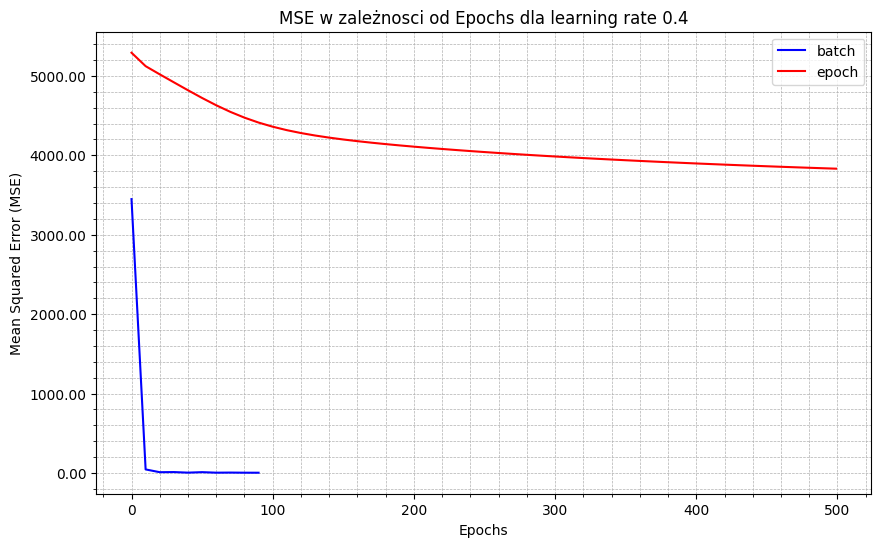

In [770]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_mse(datasets, labels, colors):
    """
    Plots MSE over epochs for given datasets with denser axes.
    
    Parameters:
    - datasets: List of Pandas DataFrames, each containing 'Epoch' and 'MSE' columns.
    - labels: List of labels for the datasets, for the legend.
    - colors: List of colors for the datasets.
    """
    plt.figure(figsize=(10, 6))
    
    ax = plt.gca()  # Get the current Axes instance on the current figure matching the given keyword args, or create one.
    
    for df, label, color in zip(datasets, labels, colors):
        plt.plot(df['Epoch'], df['MSE'], label=label, color=color)
    
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('MSE w zależnosci od Epochs dla learning rate 0.4')
    
    # Set denser x-axis and y-axis
    ax.xaxis.set_major_locator(ticker.AutoLocator())  # Automatically determine the tick locations
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())  # Subdivisions of the major ticks
    ax.yaxis.set_major_locator(ticker.AutoLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    
    # Optionally, you can format tick labels for readability, e.g., limiting the decimal places for MSE
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    
    plt.legend()
    plt.grid(visible=True, which='both', axis='both', linestyle='--', linewidth=0.5)  # Enhanced grid visibility
    plt.show()

# Assuming mse1_01, mse50_01, mse100_01, mse200_01 are your datasets as DataFrames
datasets = [mse2_batch, mse2_epoch]
labels = ['batch', 'epoch']
colors = ['blue', 'red']

plot_mse(datasets, labels, colors)


In [680]:
mse100_04 = mlp_multimodal.train(
    training_data_scaled3, epochs=500, learning_rate=0.4, batch_size=100,
    X_val_scaled=X_test_scaled3, y_val_scaled=y_test_scaled3, X_val=X_test_multimodal_large, y_val=y_test_multimodal_large,
    scaler_X=scaler_X, scaler_y=scaler_y, mse_limit=40, visual_interval=10
)

Epoch 0, MSE: 4281.1053896356525
Epoch 10, MSE: 2088.757013627313
Epoch 20, MSE: 1643.083312874097
Epoch 30, MSE: 1506.8280901161506
Epoch 40, MSE: 1166.6778269160718
Epoch 50, MSE: 888.1333202383277
Epoch 60, MSE: 653.7146364063494
Epoch 70, MSE: 637.3710301118542
Epoch 80, MSE: 491.83071135651954
Epoch 90, MSE: 451.1648725743698
Epoch 100, MSE: 420.4632314920078
Epoch 110, MSE: 388.6135401814188
Epoch 120, MSE: 401.25977749006904
Epoch 130, MSE: 379.2812804782044
Epoch 140, MSE: 364.99141678824344
Epoch 150, MSE: 356.1671169080532
Epoch 160, MSE: 368.73968293874015
Epoch 170, MSE: 344.1676293025295
Epoch 180, MSE: 339.21554580870156
Epoch 190, MSE: 341.0784294935016
Epoch 200, MSE: 357.31923744029905
Epoch 210, MSE: 333.5889428380864
Epoch 220, MSE: 325.24848116151907
Epoch 230, MSE: 326.3871465136845
Epoch 240, MSE: 323.66003323201215
Epoch 250, MSE: 322.1983988878036
Epoch 260, MSE: 316.3929050903958
Epoch 270, MSE: 327.4314602518126
Epoch 280, MSE: 314.57588039692274
Epoch 290, MS

In [681]:
mse1_1 = list_to_dataframe(mse1_1)
mse50_1 = list_to_dataframe(mse50_1)
mse100_1 = list_to_dataframe(mse100_1)
mse1_04 = list_to_dataframe(mse1_04)
mse50_04 = list_to_dataframe(mse50_04)
mse100_04 = list_to_dataframe(mse100_04)

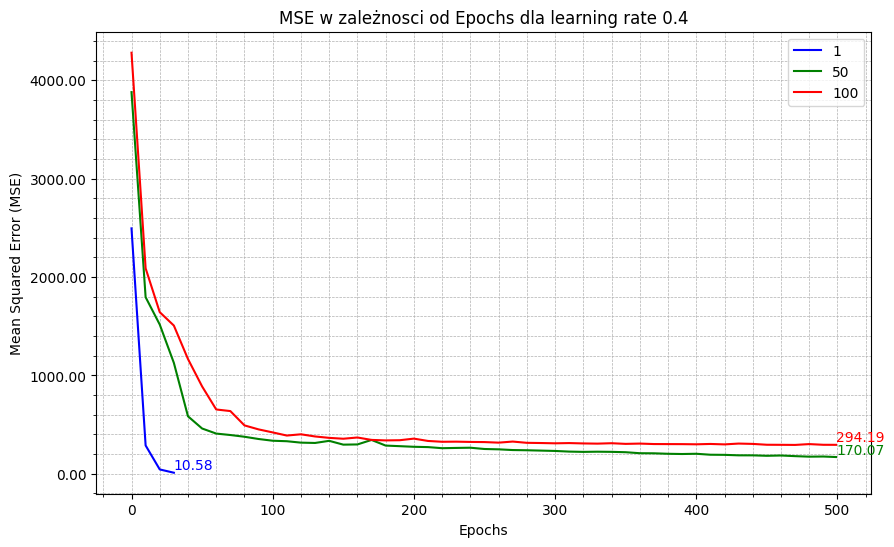

In [690]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_mse(datasets, labels, colors):
    """
    Plots MSE over epochs for given datasets with denser axes, and annotates the last MSE value.
    
    Parameters:
    - datasets: List of Pandas DataFrames, each containing 'Epoch' and 'MSE' columns.
    - labels: List of labels for the datasets, for the legend.
    - colors: List of colors for the datasets.
    """
    plt.figure(figsize=(10, 6))
    
    ax = plt.gca()
    
    for df, label, color in zip(datasets, labels, colors):
        plt.plot(df['Epoch'], df['MSE'], label=label, color=color)
        # Annotate the last MSE value
        final_epoch = df['Epoch'].iloc[-1]
        final_mse = df['MSE'].iloc[-1]
        plt.text(final_epoch, final_mse, f'{final_mse:.2f}', color=color, verticalalignment='bottom')
    
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('MSE w zależnosci od Epochs dla learning rate 0.4')
    
    ax.xaxis.set_major_locator(ticker.AutoLocator())
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_major_locator(ticker.AutoLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    

    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    
    plt.legend()
    plt.grid(visible=True, which='both', axis='both', linestyle='--', linewidth=0.5)
    plt.show()

# Assuming mse1_01, mse50_01, mse100_01, mse200_01 are your datasets as DataFrames
datasets = [mse1_04, mse50_04, mse100_04]  # Replace with actual DataFrames
labels = ['1', '50', '100']  # Customize as needed
colors = ['blue', 'green', 'red', 'purple']  # Choose your preferred colors

plot_mse(datasets, labels, colors)


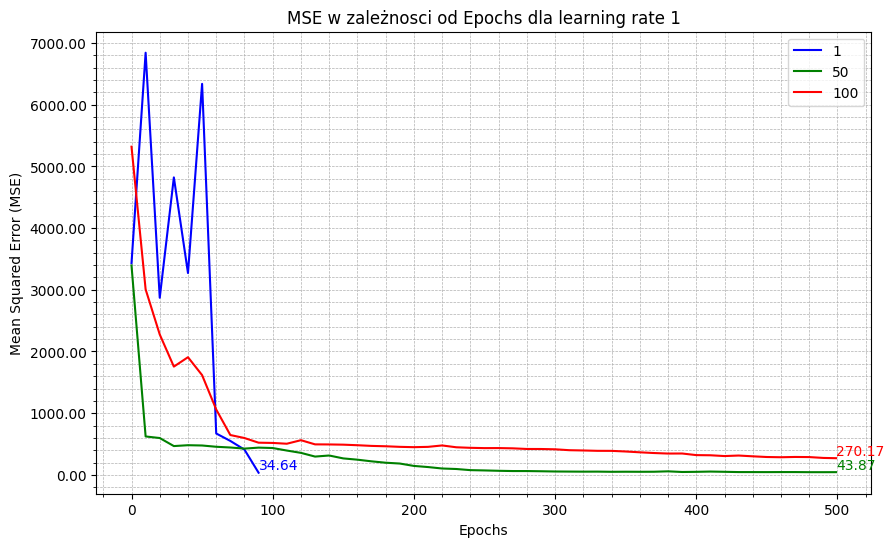

In [691]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_mse(datasets, labels, colors):
    """
    Plots MSE over epochs for given datasets with denser axes, and annotates the last MSE value.
    
    Parameters:
    - datasets: List of Pandas DataFrames, each containing 'Epoch' and 'MSE' columns.
    - labels: List of labels for the datasets, for the legend.
    - colors: List of colors for the datasets.
    """
    plt.figure(figsize=(10, 6))
    
    ax = plt.gca()
    
    for df, label, color in zip(datasets, labels, colors):
        plt.plot(df['Epoch'], df['MSE'], label=label, color=color)
        # Annotate the last MSE value
        final_epoch = df['Epoch'].iloc[-1]
        final_mse = df['MSE'].iloc[-1]
        plt.text(final_epoch, final_mse, f'{final_mse:.2f}', color=color, verticalalignment='bottom')
    
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('MSE w zależnosci od Epochs dla learning rate 1')
    
    ax.xaxis.set_major_locator(ticker.AutoLocator())
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_major_locator(ticker.AutoLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    

    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    
    plt.legend()
    plt.grid(visible=True, which='both', axis='both', linestyle='--', linewidth=0.5)
    plt.show()

# Assuming mse1_01, mse50_01, mse100_01, mse200_01 are your datasets as DataFrames
datasets = [mse1_1, mse50_1, mse100_1]  # Replace with actual DataFrames
labels = ['1', '50', '100']  # Customize as needed
colors = ['blue', 'green', 'red', 'purple']  # Choose your preferred colors

plot_mse(datasets, labels, colors)


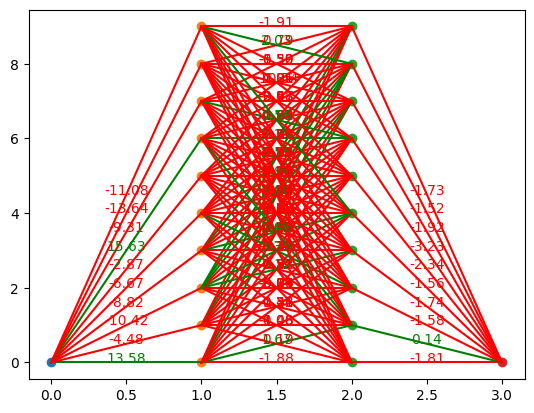

In [694]:
mlp_multimodal.visualize_network()

#### testing

In [459]:
# Scale the test data using the transform method
X_test_scaled3 = scaler_X.transform(X_test_multimodal_large)

In [460]:
# Generate predictions on the scaled test data
predictions_scaled3 = np.array(
    [mlp_multimodal.feedforward(x.reshape(-1, 1))[0] for x in X_test_scaled3]
)

In [461]:
# Correctly denormalize predictions
predictions3 = scaler_y.inverse_transform(predictions_scaled3.reshape(-1, 1))

# Calculate MSE score
for i in range(len(predictions3)):
    print("predicted value: ",  predictions3[i], "actual value: ", y_test_multimodal_large[i])
mse_score3 = mse(predictions3, y_test_multimodal_large)

print(f"MSE Score: {mse_score3}")

predicted value:  [-98.61762757] actual value:  [-98.2081664]
predicted value:  [-57.55949139] actual value:  [-55.28389066]
predicted value:  [96.81754344] actual value:  [100.29999676]
predicted value:  [-6.10210099] actual value:  [2.7206294]
predicted value:  [-76.14507474] actual value:  [-75.99163605]
predicted value:  [31.59826141] actual value:  [36.4875116]
predicted value:  [23.87751148] actual value:  [32.9071937]
predicted value:  [43.80285829] actual value:  [54.59378752]
predicted value:  [69.20004884] actual value:  [75.88595471]
predicted value:  [13.85803755] actual value:  [15.93020098]
predicted value:  [37.17074423] actual value:  [36.41048972]
predicted value:  [101.31296911] actual value:  [100.17958374]
predicted value:  [-96.29114011] actual value:  [-96.19000955]
predicted value:  [101.23356624] actual value:  [100.29859577]
predicted value:  [-66.26932765] actual value:  [-64.55778832]
predicted value:  [61.17476116] actual value:  [73.08482928]
predicted valu

In [388]:
# mse<40, zalozenie spelnione